In [1]:
%reset -f

In [2]:
!pip install --upgrade pip
!pip install tensorflow #follow https://www.tensorflow.org/install/pip
!pip install numba
!pip install sklearn
!pip install mediapipe
!pip install tqdm
!pip install seaborn

#!conda install graphviz
#!conda install pydotplus

Defaulting to user installation because normal site-packages is not writeable
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 6.4 MB/s eta 0:00:00m eta 0:00:010:00:01
  Attempting uninstall: pip
    Found existing installation: pip 23.1
    Uninstalling pip-23.1:
      Successfully uninstalled pip-23.1
Defaulting to user installation because normal site-packages is not writeable
  Attempting uninstall: flatbuffers
    Found existing installation: flatbuffers 23.3.3
    Uninstalling flatbuffers-23.3.3:
      Successfully uninstalled flatbuffers-23.3.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
mediapipe 0.9.3.0 requires flatbuffers>=2.0, but you have flatbuffers 1.12 which is incompatible.
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Defau

  Attempting uninstall: flatbuffers
    Found existing installation: flatbuffers 1.12
    Uninstalling flatbuffers-1.12:
      Successfully uninstalled flatbuffers-1.12
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow 2.9.0 requires flatbuffers<2,>=1.12, but you have flatbuffers 23.3.3 which is incompatible.
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable


In [3]:
import tensorflow as tf
import sklearn
import mediapipe as mp
import cv2
import numpy as np
import seaborn as sns

from sklearn import datasets
from sklearn import model_selection
from numba import cuda
from matplotlib import pyplot as plt
from tqdm import tqdm

#Python libraries
import os
import random
from datetime import datetime
from pathlib import Path
from collections import Counter

In [4]:
#Seed data, to ensure that between runs, the results would not differ
seed = 1
random.seed(seed)
np.random.seed(seed)
tf.random.set_seed(seed)
tf.experimental.numpy.random.seed(seed)
os.environ["TF_CUDNN_DETERMINISTIC"] = str(seed)
os.environ["TF_DETERMINISTIC_OPS"] = str(seed)
os.environ["PYTHONHASHSEED"] = str(seed)
tf.config.threading.set_inter_op_parallelism_threads(1)
tf.config.threading.set_intra_op_parallelism_threads(1)

In [5]:
#Check we are running tensorflow in GPU mode.
device = cuda.get_current_device()
device.reset()
gpus = tf.config.list_physical_devices("GPU")
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
            logical_gpus = tf.config.list_logical_devices("GPU")
            print("{} physical GPU and {} logical GPU".format(len(gpus), len(logical_gpus)))
    except RuntimeError as e:
        print(e)

1 physical GPU and 1 logical GPU


### Data Loading

In [6]:
#Load the data as files.

raw_data = sklearn.datasets.load_files(os.getcwd() + r"/data", shuffle = False, random_state = seed)
files = raw_data["filenames"]
targets = raw_data["target"]

class_names = np.array(raw_data["target_names"])
number_of_classes = len(class_names)
label_map = {label:num for num, label in enumerate(class_names)} #{"class_name": 0, ...}

### Drawing Code and Helper Functions

In [7]:
#A function to pad the data array with 0s
def pad_array(input_array, new_shape):
    first, second = np.shape(input_array)
    output_array = np.zeros(new_shape)
    output_array[0:first, 0:second] = input_array
    return output_array

In [8]:
#Normalise function to normalise the keypoint data so it's easier for the network
scaler = sklearn.preprocessing.MinMaxScaler(feature_range=(10, 11))

In [9]:
#Mediapipe parameters and variables
min_detect = 0.7 #non-default
min_track = 0.7 #non-default
segmentation = False #default
model_complex = 1 #default

mp_drawing = mp.solutions.drawing_utils
mp_drawing_styles = mp.solutions.drawing_styles
mp_pose = mp.solutions.pose

In [10]:
#Add keypoint data to each frame
def mediapipe_detection(image, pose):
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image.flags.writeable = False
    results = pose.process(image)
    image.flags.writeable = True
    image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)

    mp_drawing.draw_landmarks(image, results.pose_landmarks, mp_pose.POSE_CONNECTIONS, 
                              landmark_drawing_spec = mp_drawing_styles.get_default_pose_landmarks_style())
    return image, results

In [11]:
#Extract keypoint data to each frame
def extract_keypoints(results):
    if results.pose_landmarks:
        output = np.array([[result.x, result.y, result.z, result.visibility] for result in results.pose_landmarks.landmark]).flatten()
        return output
    else:
        return None

In [12]:
#Forms a 3D array of (samples, timestep, keypoints_length) of all input samples
def keypoint_maker(video_list, shape):
    video_array = []
    with mp_pose.Pose(min_detection_confidence = min_detect, min_tracking_confidence = min_track,
                      model_complexity = model_complex, enable_segmentation = segmentation) as pose:
        
        for video in tqdm(video_list):
            cap = cv2.VideoCapture(video)
            keypoints_list = []
            while cap.isOpened():
                ret, frame = cap.read()
                if not ret:
                    break
                image, results = mediapipe_detection(frame, pose)
                keypoints = extract_keypoints(results)
                if keypoints is not None:
                    keypoints_list.append(keypoints)
                else:
                    continue
            video = np.stack(keypoints_list, axis = 0)
            video = scaler.fit_transform(video)
            video = pad_array(video, shape) #pads to largest video
            video = np.expand_dims(video, axis=0) #Turns (frame_size, keypoints_length) into (1, frame_size, keypoints_length)
            video_array.append(video) #Add current video to list
            cap.release()
            cv2.destroyAllWindows()
        tensor = np.vstack(video_array)
        return tensor

In [13]:
#Helper function to see all the frames as images in a folder to check them
def save_frames(video_list):
    frame_folder = "/frames_" + str(min_detect) + "_" + str(min_track) + "_" + str(segmentation) + "_" + str(model_complex) + "/"
    frame_path = os.getcwd() + frame_folder
    
    if not os.path.exists(frame_path):
        os.mkdir(frame_path)
    
    with mp_pose.Pose(min_detection_confidence = min_detect, min_tracking_confidence = min_track,
                      model_complexity = model_complex, enable_segmentation = segmentation) as pose:
        
        for video in tqdm(video_list):
            cap = cv2.VideoCapture(video)
            count = 0
            while cap.isOpened():
                ret, frame = cap.read()
                if not ret:
                    break
                image, results = mediapipe_detection(frame, pose)
                keypoints = extract_keypoints(results)
                file_name = frame_path + "/" + str(Path(video).stem) + "_" + str(count) + ".jpeg"
                cv2.imwrite(file_name, image)  
                count += 1
            cap.release()
            cv2.destroyAllWindows()

In [14]:
#Gives information on the videos such as FPS and the video with most frames.
def get_video_frame_data(video_list):
    frame_array = []
    fps_array = []
    with mp_pose.Pose(min_detection_confidence=min_detect, min_tracking_confidence=min_track,
                      model_complexity = model_complex, enable_segmentation=segmentation) as pose:
        for video in tqdm(video_list):
            cap = cv2.VideoCapture(video)
            frame_length = 0
            number_of_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
            fps = cap.get(cv2.CAP_PROP_FPS)
            frame_array.append(number_of_frames)
            fps_array.append(fps)
            cap.release()
            cv2.destroyAllWindows()
    longest_video = max(frame_array)
    return frame_array, fps_array

### Data Splitting/Processing

In [15]:
train_ratio = 0.80
validation_ratio = 0.10
test_ratio = 0.10

In [16]:
#First slipts the train and test
train_files, test_files, train_targets, test_targets = model_selection.train_test_split(files, 
                                                                                        targets, 
                                                                                        test_size=1 - train_ratio, 
                                                                                        random_state = seed, 
                                                                                        stratify = targets)
#Then splits the test into validation and test.
valid_files, test_files, valid_targets, test_targets = model_selection.train_test_split(test_files,
                                                                                        test_targets,
                                                                                        test_size = test_ratio / (test_ratio + validation_ratio),
                                                                                        random_state = seed,
                                                                                        stratify = test_targets)

In [17]:
#Useful information
video_data = get_video_frame_data(files)
frame_limit = max(video_data[0])
fps_array = video_data[1]
fps_min = min(fps_array)
fps_max = max(fps_array)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 180/180 [00:00<00:00, 234.61it/s]


In [18]:
#Takes a long time so commented out until final run
save_frames(files)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 180/180 [05:35<00:00,  1.87s/it]


In [19]:
#Useful information printed
print(frame_limit)
print(fps_min)
print(fps_max)

188
30.16042780748663
31.11111111111111


In [20]:
#Ensure each set has an equally split number of classes, otherwise network is potentially biased to certain classes.
print(np.bincount(train_targets))
print(np.bincount(valid_targets))
print(np.bincount(test_targets))

[48 48 48]
[6 6 6]
[6 6 6]


In [21]:
#Set the shape and form the train, validation, and test sets of data as keypoint arrays

shape = list((len(files), frame_limit, 132)) #number of videos, number of frames, number of keypoints
x_train = keypoint_maker(train_files, shape[1:])
x_valid = keypoint_maker(valid_files, shape[1:])
x_test = keypoint_maker(test_files, shape[1:])
y_train = tf.keras.utils.to_categorical(train_targets, num_classes=number_of_classes)
y_valid = tf.keras.utils.to_categorical(valid_targets, num_classes=number_of_classes)
y_test = tf.keras.utils.to_categorical(test_targets, num_classes=number_of_classes)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:25<00:00,  1.41s/it]


In [22]:
print("Shape of all data:", shape)
print("Shape of training data:", x_train.shape)
print("Shape of training labels:", y_train.shape)
print("Shape of validation data:", x_valid.shape)
print("Shape of validation labels:", y_valid.shape)
print("Shape of testing data:", x_test.shape)
print("Shape of testing labels:", y_test.shape)

Shape of all data: [180, 188, 132]
Shape of training data: (144, 188, 132)
Shape of training labels: (144, 3)
Shape of validation data: (18, 188, 132)
Shape of validation labels: (18, 3)
Shape of testing data: (18, 188, 132)
Shape of testing labels: (18, 3)


### Model Layers & Paramers

In [23]:
strides = 1
padding= "same"
activation_conv = "tanh"
activation_lstm = "tanh"
filters_conv = [128, 64, 32]
filters_lstm = [128, 64, 32]
kernel_size = [5,3,1]
return_sequences = True

MODEL = [
    tf.keras.layers.Masking(mask_value = 0., input_shape = shape[1:]),
    tf.keras.layers.Conv1D(filters_conv[0], kernel_size = kernel_size[0], strides = strides, padding = padding, activation = activation_conv),
    tf.keras.layers.LSTM(filters_lstm[0], activation = activation_lstm, return_sequences = return_sequences),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Conv1D(filters_conv[1], kernel_size = kernel_size[1], strides = strides, padding = padding, activation = activation_conv),
    tf.keras.layers.LSTM(filters_lstm[1], activation = activation_lstm, return_sequences = return_sequences),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Conv1D(filters_conv[2], kernel_size = kernel_size[2], strides = strides, padding = padding, activation = activation_conv),
    tf.keras.layers.LSTM(filters_lstm[2], activation = activation_lstm, return_sequences = return_sequences),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(number_of_classes, activation="softmax")]

In [24]:
model = tf.keras.Sequential(MODEL)
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 masking (Masking)           (None, 188, 132)          0         
                                                                 
 conv1d (Conv1D)             (None, 188, 128)          84608     
                                                                 
 lstm (LSTM)                 (None, 188, 128)          131584    
                                                                 
 batch_normalization (BatchN  (None, 188, 128)         512       
 ormalization)                                                   
                                                                 
 conv1d_1 (Conv1D)           (None, 188, 64)           24640     
                                                                 
 lstm_1 (LSTM)               (None, 188, 64)           33024     
                                                        

In [25]:
#tf.keras.utils.plot_model(model,to_file = "model.png", show_shapes = True, show_layer_activations = True)

In [26]:
batch_size = x_train.shape[0]
epochs = 2000
learning_rate = 0.00001
optimizer = tf.keras.optimizers.Adam(learning_rate = learning_rate)
loss = tf.keras.losses.CategoricalCrossentropy()
metrics = ["accuracy"]
model_file = "model.hdf5"

model.compile(optimizer = optimizer, loss = loss, metrics = metrics)

checkpoint = tf.keras.callbacks.ModelCheckpoint(filepath = model_file, monitor = "val_loss", save_best_only = True)

callbacks = [checkpoint]

history=model.fit(x_train, y_train, batch_size = batch_size, epochs = epochs, validation_data = (x_valid, y_valid),
                  callbacks = callbacks, verbose = 1)

Epoch 1/2000


2023-04-28 08:22:30.598028: W tensorflow/stream_executor/gpu/asm_compiler.cc:80] Couldn't get ptxas version string: INTERNAL: Couldn't invoke ptxas --version
2023-04-28 08:22:30.598674: W tensorflow/stream_executor/gpu/redzone_allocator.cc:314] INTERNAL: Failed to launch ptxas
Relying on driver to perform ptx compilation. 
Modify $PATH to customize ptxas location.
This message will be only logged once.


1/1 [==============================] - 5s 5s/step - loss: 1.4349 - accuracy: 0.2569 - val_loss: 1.0971 - val_accuracy: 0.4444
Epoch 2/2000
1/1 [==============================] - 0s 123ms/step - loss: 1.3131 - accuracy: 0.3125 - val_loss: 1.0970 - val_accuracy: 0.4444
Epoch 3/2000
1/1 [==============================] - 0s 108ms/step - loss: 1.2494 - accuracy: 0.3750 - val_loss: 1.0969 - val_accuracy: 0.4444
Epoch 4/2000
1/1 [==============================] - 0s 115ms/step - loss: 1.2149 - accuracy: 0.4167 - val_loss: 1.0966 - val_accuracy: 0.4444
Epoch 5/2000
1/1 [==============================] - 0s 111ms/step - loss: 1.1757 - accuracy: 0.4306 - val_loss: 1.0962 - val_accuracy: 0.4444
Epoch 6/2000
1/1 [==============================] - 0s 108ms/step - loss: 1.1298 - accuracy: 0.4583 - val_loss: 1.0956 - val_accuracy: 0.4444
Epoch 7/2000
1/1 [==============================] - 0s 110ms/step - loss: 1.0876 - accuracy: 0.4722 - val_loss: 1.0949 - val_accuracy: 0.4444
Epoch 8/2000
1/1 [====

1/1 [==============================] - 0s 114ms/step - loss: 0.5023 - accuracy: 0.8264 - val_loss: 1.0645 - val_accuracy: 0.5556
Epoch 59/2000
1/1 [==============================] - 0s 117ms/step - loss: 0.4967 - accuracy: 0.8194 - val_loss: 1.0637 - val_accuracy: 0.5556
Epoch 60/2000
1/1 [==============================] - 0s 113ms/step - loss: 0.4911 - accuracy: 0.8264 - val_loss: 1.0630 - val_accuracy: 0.5556
Epoch 61/2000
1/1 [==============================] - 0s 123ms/step - loss: 0.4856 - accuracy: 0.8472 - val_loss: 1.0622 - val_accuracy: 0.5556
Epoch 62/2000
1/1 [==============================] - 0s 112ms/step - loss: 0.4803 - accuracy: 0.8542 - val_loss: 1.0614 - val_accuracy: 0.5556
Epoch 63/2000
1/1 [==============================] - 0s 107ms/step - loss: 0.4751 - accuracy: 0.8542 - val_loss: 1.0607 - val_accuracy: 0.5556
Epoch 64/2000
1/1 [==============================] - 0s 111ms/step - loss: 0.4697 - accuracy: 0.8542 - val_loss: 1.0600 - val_accuracy: 0.5556
Epoch 65/2000

1/1 [==============================] - 0s 122ms/step - loss: 0.2469 - accuracy: 0.9653 - val_loss: 1.0291 - val_accuracy: 0.6111
Epoch 116/2000
1/1 [==============================] - 0s 126ms/step - loss: 0.2456 - accuracy: 0.9583 - val_loss: 1.0286 - val_accuracy: 0.6111
Epoch 117/2000
1/1 [==============================] - 0s 113ms/step - loss: 0.2420 - accuracy: 0.9722 - val_loss: 1.0280 - val_accuracy: 0.6111
Epoch 118/2000
1/1 [==============================] - 0s 127ms/step - loss: 0.2399 - accuracy: 0.9653 - val_loss: 1.0274 - val_accuracy: 0.6111
Epoch 119/2000
1/1 [==============================] - 0s 107ms/step - loss: 0.2375 - accuracy: 0.9653 - val_loss: 1.0269 - val_accuracy: 0.6111
Epoch 120/2000
1/1 [==============================] - 0s 126ms/step - loss: 0.2345 - accuracy: 0.9653 - val_loss: 1.0264 - val_accuracy: 0.6111
Epoch 121/2000
1/1 [==============================] - 0s 108ms/step - loss: 0.2328 - accuracy: 0.9722 - val_loss: 1.0259 - val_accuracy: 0.6111
Epoch 1

Epoch 172/2000
1/1 [==============================] - 0s 124ms/step - loss: 0.1408 - accuracy: 1.0000 - val_loss: 1.0043 - val_accuracy: 0.5556
Epoch 173/2000
1/1 [==============================] - 0s 120ms/step - loss: 0.1395 - accuracy: 1.0000 - val_loss: 1.0039 - val_accuracy: 0.5556
Epoch 174/2000
1/1 [==============================] - 0s 124ms/step - loss: 0.1382 - accuracy: 1.0000 - val_loss: 1.0036 - val_accuracy: 0.5556
Epoch 175/2000
1/1 [==============================] - 0s 133ms/step - loss: 0.1370 - accuracy: 1.0000 - val_loss: 1.0032 - val_accuracy: 0.5556
Epoch 176/2000
1/1 [==============================] - 0s 209ms/step - loss: 0.1357 - accuracy: 1.0000 - val_loss: 1.0029 - val_accuracy: 0.5556
Epoch 177/2000
1/1 [==============================] - 0s 183ms/step - loss: 0.1344 - accuracy: 1.0000 - val_loss: 1.0026 - val_accuracy: 0.5556
Epoch 178/2000
1/1 [==============================] - 0s 136ms/step - loss: 0.1332 - accuracy: 1.0000 - val_loss: 1.0023 - val_accuracy:

Epoch 229/2000
1/1 [==============================] - 0s 134ms/step - loss: 0.0860 - accuracy: 1.0000 - val_loss: 0.9948 - val_accuracy: 0.4444
Epoch 230/2000
1/1 [==============================] - 0s 123ms/step - loss: 0.0853 - accuracy: 1.0000 - val_loss: 0.9948 - val_accuracy: 0.4444
Epoch 231/2000
1/1 [==============================] - 0s 125ms/step - loss: 0.0846 - accuracy: 1.0000 - val_loss: 0.9947 - val_accuracy: 0.4444
Epoch 232/2000
1/1 [==============================] - 0s 124ms/step - loss: 0.0840 - accuracy: 1.0000 - val_loss: 0.9946 - val_accuracy: 0.4444
Epoch 233/2000
1/1 [==============================] - 0s 121ms/step - loss: 0.0833 - accuracy: 1.0000 - val_loss: 0.9946 - val_accuracy: 0.4444
Epoch 234/2000
1/1 [==============================] - 0s 129ms/step - loss: 0.0827 - accuracy: 1.0000 - val_loss: 0.9945 - val_accuracy: 0.4444
Epoch 235/2000
1/1 [==============================] - 0s 146ms/step - loss: 0.0820 - accuracy: 1.0000 - val_loss: 0.9944 - val_accuracy:

1/1 [==============================] - 0s 123ms/step - loss: 0.0561 - accuracy: 1.0000 - val_loss: 0.9916 - val_accuracy: 0.2778
Epoch 287/2000
1/1 [==============================] - 0s 123ms/step - loss: 0.0557 - accuracy: 1.0000 - val_loss: 0.9913 - val_accuracy: 0.2778
Epoch 288/2000
1/1 [==============================] - 0s 76ms/step - loss: 0.0554 - accuracy: 1.0000 - val_loss: 0.9913 - val_accuracy: 0.2778
Epoch 289/2000
1/1 [==============================] - 0s 119ms/step - loss: 0.0550 - accuracy: 1.0000 - val_loss: 0.9909 - val_accuracy: 0.2778
Epoch 290/2000
1/1 [==============================] - 0s 78ms/step - loss: 0.0546 - accuracy: 1.0000 - val_loss: 0.9909 - val_accuracy: 0.2778
Epoch 291/2000
1/1 [==============================] - 0s 119ms/step - loss: 0.0542 - accuracy: 1.0000 - val_loss: 0.9906 - val_accuracy: 0.2778
Epoch 292/2000
1/1 [==============================] - 0s 122ms/step - loss: 0.0539 - accuracy: 1.0000 - val_loss: 0.9904 - val_accuracy: 0.2778
Epoch 293

1/1 [==============================] - 0s 134ms/step - loss: 0.0385 - accuracy: 1.0000 - val_loss: 0.9645 - val_accuracy: 0.3889
Epoch 344/2000
1/1 [==============================] - 0s 138ms/step - loss: 0.0383 - accuracy: 1.0000 - val_loss: 0.9638 - val_accuracy: 0.4444
Epoch 345/2000
1/1 [==============================] - 0s 117ms/step - loss: 0.0380 - accuracy: 1.0000 - val_loss: 0.9624 - val_accuracy: 0.5000
Epoch 346/2000
1/1 [==============================] - 0s 131ms/step - loss: 0.0378 - accuracy: 1.0000 - val_loss: 0.9619 - val_accuracy: 0.5000
Epoch 347/2000
1/1 [==============================] - 0s 132ms/step - loss: 0.0376 - accuracy: 1.0000 - val_loss: 0.9603 - val_accuracy: 0.5000
Epoch 348/2000
1/1 [==============================] - 0s 119ms/step - loss: 0.0373 - accuracy: 1.0000 - val_loss: 0.9599 - val_accuracy: 0.5000
Epoch 349/2000
1/1 [==============================] - 0s 120ms/step - loss: 0.0371 - accuracy: 1.0000 - val_loss: 0.9583 - val_accuracy: 0.5000
Epoch 3

Epoch 400/2000
1/1 [==============================] - 0s 120ms/step - loss: 0.0275 - accuracy: 1.0000 - val_loss: 0.8711 - val_accuracy: 0.6667
Epoch 401/2000
1/1 [==============================] - 0s 123ms/step - loss: 0.0274 - accuracy: 1.0000 - val_loss: 0.8689 - val_accuracy: 0.6667
Epoch 402/2000
1/1 [==============================] - 0s 128ms/step - loss: 0.0272 - accuracy: 1.0000 - val_loss: 0.8659 - val_accuracy: 0.6667
Epoch 403/2000
1/1 [==============================] - 0s 126ms/step - loss: 0.0271 - accuracy: 1.0000 - val_loss: 0.8638 - val_accuracy: 0.6667
Epoch 404/2000
1/1 [==============================] - 0s 129ms/step - loss: 0.0269 - accuracy: 1.0000 - val_loss: 0.8605 - val_accuracy: 0.6667
Epoch 405/2000
1/1 [==============================] - 0s 117ms/step - loss: 0.0268 - accuracy: 1.0000 - val_loss: 0.8588 - val_accuracy: 0.6667
Epoch 406/2000
1/1 [==============================] - 0s 119ms/step - loss: 0.0266 - accuracy: 1.0000 - val_loss: 0.8549 - val_accuracy:

Epoch 457/2000
1/1 [==============================] - 0s 119ms/step - loss: 0.0206 - accuracy: 1.0000 - val_loss: 0.6851 - val_accuracy: 0.8333
Epoch 458/2000
1/1 [==============================] - 0s 117ms/step - loss: 0.0205 - accuracy: 1.0000 - val_loss: 0.6808 - val_accuracy: 0.8333
Epoch 459/2000
1/1 [==============================] - 0s 116ms/step - loss: 0.0204 - accuracy: 1.0000 - val_loss: 0.6773 - val_accuracy: 0.8333
Epoch 460/2000
1/1 [==============================] - 0s 118ms/step - loss: 0.0203 - accuracy: 1.0000 - val_loss: 0.6730 - val_accuracy: 0.8333
Epoch 461/2000
1/1 [==============================] - 0s 122ms/step - loss: 0.0202 - accuracy: 1.0000 - val_loss: 0.6692 - val_accuracy: 0.8333
Epoch 462/2000
1/1 [==============================] - 0s 122ms/step - loss: 0.0201 - accuracy: 1.0000 - val_loss: 0.6653 - val_accuracy: 0.8333
Epoch 463/2000
1/1 [==============================] - 0s 131ms/step - loss: 0.0200 - accuracy: 1.0000 - val_loss: 0.6611 - val_accuracy:

Epoch 514/2000
1/1 [==============================] - 0s 119ms/step - loss: 0.0160 - accuracy: 1.0000 - val_loss: 0.4481 - val_accuracy: 0.8333
Epoch 515/2000
1/1 [==============================] - 0s 122ms/step - loss: 0.0159 - accuracy: 1.0000 - val_loss: 0.4438 - val_accuracy: 0.8333
Epoch 516/2000
1/1 [==============================] - 0s 117ms/step - loss: 0.0158 - accuracy: 1.0000 - val_loss: 0.4397 - val_accuracy: 0.8333
Epoch 517/2000
1/1 [==============================] - 0s 119ms/step - loss: 0.0158 - accuracy: 1.0000 - val_loss: 0.4355 - val_accuracy: 0.8333
Epoch 518/2000
1/1 [==============================] - 0s 120ms/step - loss: 0.0157 - accuracy: 1.0000 - val_loss: 0.4313 - val_accuracy: 0.8333
Epoch 519/2000
1/1 [==============================] - 0s 118ms/step - loss: 0.0156 - accuracy: 1.0000 - val_loss: 0.4271 - val_accuracy: 0.8333
Epoch 520/2000
1/1 [==============================] - 0s 116ms/step - loss: 0.0156 - accuracy: 1.0000 - val_loss: 0.4230 - val_accuracy:

Epoch 571/2000
1/1 [==============================] - 0s 119ms/step - loss: 0.0127 - accuracy: 1.0000 - val_loss: 0.2431 - val_accuracy: 0.9444
Epoch 572/2000
1/1 [==============================] - 0s 121ms/step - loss: 0.0126 - accuracy: 1.0000 - val_loss: 0.2403 - val_accuracy: 0.9444
Epoch 573/2000
1/1 [==============================] - 0s 117ms/step - loss: 0.0126 - accuracy: 1.0000 - val_loss: 0.2376 - val_accuracy: 0.9444
Epoch 574/2000
1/1 [==============================] - 0s 122ms/step - loss: 0.0125 - accuracy: 1.0000 - val_loss: 0.2348 - val_accuracy: 0.9444
Epoch 575/2000
1/1 [==============================] - 0s 118ms/step - loss: 0.0125 - accuracy: 1.0000 - val_loss: 0.2322 - val_accuracy: 0.9444
Epoch 576/2000
1/1 [==============================] - 0s 117ms/step - loss: 0.0124 - accuracy: 1.0000 - val_loss: 0.2295 - val_accuracy: 0.9444
Epoch 577/2000
1/1 [==============================] - 0s 120ms/step - loss: 0.0124 - accuracy: 1.0000 - val_loss: 0.2269 - val_accuracy:

Epoch 628/2000
1/1 [==============================] - 0s 122ms/step - loss: 0.0103 - accuracy: 1.0000 - val_loss: 0.1344 - val_accuracy: 0.9444
Epoch 629/2000
1/1 [==============================] - 0s 122ms/step - loss: 0.0103 - accuracy: 1.0000 - val_loss: 0.1332 - val_accuracy: 0.9444
Epoch 630/2000
1/1 [==============================] - 0s 117ms/step - loss: 0.0102 - accuracy: 1.0000 - val_loss: 0.1320 - val_accuracy: 0.9444
Epoch 631/2000
1/1 [==============================] - 0s 119ms/step - loss: 0.0102 - accuracy: 1.0000 - val_loss: 0.1309 - val_accuracy: 0.9444
Epoch 632/2000
1/1 [==============================] - 0s 119ms/step - loss: 0.0102 - accuracy: 1.0000 - val_loss: 0.1297 - val_accuracy: 0.9444
Epoch 633/2000
1/1 [==============================] - 0s 123ms/step - loss: 0.0101 - accuracy: 1.0000 - val_loss: 0.1286 - val_accuracy: 0.9444
Epoch 634/2000
1/1 [==============================] - 0s 118ms/step - loss: 0.0101 - accuracy: 1.0000 - val_loss: 0.1275 - val_accuracy:

Epoch 685/2000
1/1 [==============================] - 0s 112ms/step - loss: 0.0086 - accuracy: 1.0000 - val_loss: 0.0877 - val_accuracy: 1.0000
Epoch 686/2000
1/1 [==============================] - 0s 118ms/step - loss: 0.0085 - accuracy: 1.0000 - val_loss: 0.0870 - val_accuracy: 1.0000
Epoch 687/2000
1/1 [==============================] - 0s 116ms/step - loss: 0.0085 - accuracy: 1.0000 - val_loss: 0.0868 - val_accuracy: 1.0000
Epoch 688/2000
1/1 [==============================] - 0s 113ms/step - loss: 0.0085 - accuracy: 1.0000 - val_loss: 0.0860 - val_accuracy: 1.0000
Epoch 689/2000
1/1 [==============================] - 0s 113ms/step - loss: 0.0085 - accuracy: 1.0000 - val_loss: 0.0857 - val_accuracy: 1.0000
Epoch 690/2000
1/1 [==============================] - 0s 119ms/step - loss: 0.0084 - accuracy: 1.0000 - val_loss: 0.0851 - val_accuracy: 1.0000
Epoch 691/2000
1/1 [==============================] - 0s 112ms/step - loss: 0.0084 - accuracy: 1.0000 - val_loss: 0.0846 - val_accuracy:

Epoch 742/2000
1/1 [==============================] - 0s 114ms/step - loss: 0.0072 - accuracy: 1.0000 - val_loss: 0.0665 - val_accuracy: 1.0000
Epoch 743/2000
1/1 [==============================] - 0s 110ms/step - loss: 0.0072 - accuracy: 1.0000 - val_loss: 0.0663 - val_accuracy: 1.0000
Epoch 744/2000
1/1 [==============================] - 0s 110ms/step - loss: 0.0072 - accuracy: 1.0000 - val_loss: 0.0661 - val_accuracy: 1.0000
Epoch 745/2000
1/1 [==============================] - 0s 113ms/step - loss: 0.0072 - accuracy: 1.0000 - val_loss: 0.0659 - val_accuracy: 1.0000
Epoch 746/2000
1/1 [==============================] - 0s 108ms/step - loss: 0.0072 - accuracy: 1.0000 - val_loss: 0.0656 - val_accuracy: 1.0000
Epoch 747/2000
1/1 [==============================] - 0s 112ms/step - loss: 0.0071 - accuracy: 1.0000 - val_loss: 0.0655 - val_accuracy: 1.0000
Epoch 748/2000
1/1 [==============================] - 0s 112ms/step - loss: 0.0071 - accuracy: 1.0000 - val_loss: 0.0653 - val_accuracy:

1/1 [==============================] - 0s 109ms/step - loss: 0.0062 - accuracy: 1.0000 - val_loss: 0.0554 - val_accuracy: 1.0000
Epoch 800/2000
1/1 [==============================] - 0s 73ms/step - loss: 0.0062 - accuracy: 1.0000 - val_loss: 0.0555 - val_accuracy: 1.0000
Epoch 801/2000
1/1 [==============================] - 0s 71ms/step - loss: 0.0062 - accuracy: 1.0000 - val_loss: 0.0556 - val_accuracy: 1.0000
Epoch 802/2000
1/1 [==============================] - 0s 110ms/step - loss: 0.0062 - accuracy: 1.0000 - val_loss: 0.0549 - val_accuracy: 1.0000
Epoch 803/2000
1/1 [==============================] - 0s 70ms/step - loss: 0.0061 - accuracy: 1.0000 - val_loss: 0.0551 - val_accuracy: 1.0000
Epoch 804/2000
1/1 [==============================] - 0s 68ms/step - loss: 0.0061 - accuracy: 1.0000 - val_loss: 0.0549 - val_accuracy: 1.0000
Epoch 805/2000
1/1 [==============================] - 0s 113ms/step - loss: 0.0061 - accuracy: 1.0000 - val_loss: 0.0544 - val_accuracy: 1.0000
Epoch 806/2

1/1 [==============================] - 0s 109ms/step - loss: 0.0054 - accuracy: 1.0000 - val_loss: 0.0462 - val_accuracy: 1.0000
Epoch 857/2000
1/1 [==============================] - 0s 110ms/step - loss: 0.0054 - accuracy: 1.0000 - val_loss: 0.0461 - val_accuracy: 1.0000
Epoch 858/2000
1/1 [==============================] - 0s 111ms/step - loss: 0.0053 - accuracy: 1.0000 - val_loss: 0.0460 - val_accuracy: 1.0000
Epoch 859/2000
1/1 [==============================] - 0s 109ms/step - loss: 0.0053 - accuracy: 1.0000 - val_loss: 0.0459 - val_accuracy: 1.0000
Epoch 860/2000
1/1 [==============================] - 0s 111ms/step - loss: 0.0053 - accuracy: 1.0000 - val_loss: 0.0458 - val_accuracy: 1.0000
Epoch 861/2000
1/1 [==============================] - 0s 120ms/step - loss: 0.0053 - accuracy: 1.0000 - val_loss: 0.0458 - val_accuracy: 1.0000
Epoch 862/2000
1/1 [==============================] - 0s 110ms/step - loss: 0.0053 - accuracy: 1.0000 - val_loss: 0.0457 - val_accuracy: 1.0000
Epoch 8

Epoch 913/2000
1/1 [==============================] - 0s 110ms/step - loss: 0.0047 - accuracy: 1.0000 - val_loss: 0.0419 - val_accuracy: 1.0000
Epoch 914/2000
1/1 [==============================] - 0s 121ms/step - loss: 0.0047 - accuracy: 1.0000 - val_loss: 0.0419 - val_accuracy: 1.0000
Epoch 915/2000
1/1 [==============================] - 0s 114ms/step - loss: 0.0047 - accuracy: 1.0000 - val_loss: 0.0418 - val_accuracy: 1.0000
Epoch 916/2000
1/1 [==============================] - 0s 115ms/step - loss: 0.0047 - accuracy: 1.0000 - val_loss: 0.0418 - val_accuracy: 1.0000
Epoch 917/2000
1/1 [==============================] - 0s 111ms/step - loss: 0.0046 - accuracy: 1.0000 - val_loss: 0.0417 - val_accuracy: 1.0000
Epoch 918/2000
1/1 [==============================] - 0s 117ms/step - loss: 0.0046 - accuracy: 1.0000 - val_loss: 0.0417 - val_accuracy: 1.0000
Epoch 919/2000
1/1 [==============================] - 0s 112ms/step - loss: 0.0046 - accuracy: 1.0000 - val_loss: 0.0416 - val_accuracy:

Epoch 970/2000
1/1 [==============================] - 0s 109ms/step - loss: 0.0041 - accuracy: 1.0000 - val_loss: 0.0392 - val_accuracy: 1.0000
Epoch 971/2000
1/1 [==============================] - 0s 112ms/step - loss: 0.0041 - accuracy: 1.0000 - val_loss: 0.0392 - val_accuracy: 1.0000
Epoch 972/2000
1/1 [==============================] - 0s 108ms/step - loss: 0.0041 - accuracy: 1.0000 - val_loss: 0.0391 - val_accuracy: 1.0000
Epoch 973/2000
1/1 [==============================] - 0s 112ms/step - loss: 0.0041 - accuracy: 1.0000 - val_loss: 0.0391 - val_accuracy: 1.0000
Epoch 974/2000
1/1 [==============================] - 0s 111ms/step - loss: 0.0041 - accuracy: 1.0000 - val_loss: 0.0391 - val_accuracy: 1.0000
Epoch 975/2000
1/1 [==============================] - 0s 110ms/step - loss: 0.0041 - accuracy: 1.0000 - val_loss: 0.0390 - val_accuracy: 1.0000
Epoch 976/2000
1/1 [==============================] - 0s 110ms/step - loss: 0.0041 - accuracy: 1.0000 - val_loss: 0.0390 - val_accuracy:

Epoch 1027/2000
1/1 [==============================] - 0s 111ms/step - loss: 0.0037 - accuracy: 1.0000 - val_loss: 0.0372 - val_accuracy: 1.0000
Epoch 1028/2000
1/1 [==============================] - 0s 112ms/step - loss: 0.0037 - accuracy: 1.0000 - val_loss: 0.0372 - val_accuracy: 1.0000
Epoch 1029/2000
1/1 [==============================] - 0s 115ms/step - loss: 0.0037 - accuracy: 1.0000 - val_loss: 0.0372 - val_accuracy: 1.0000
Epoch 1030/2000
1/1 [==============================] - 0s 110ms/step - loss: 0.0036 - accuracy: 1.0000 - val_loss: 0.0371 - val_accuracy: 1.0000
Epoch 1031/2000
1/1 [==============================] - 0s 113ms/step - loss: 0.0036 - accuracy: 1.0000 - val_loss: 0.0371 - val_accuracy: 1.0000
Epoch 1032/2000
1/1 [==============================] - 0s 111ms/step - loss: 0.0036 - accuracy: 1.0000 - val_loss: 0.0371 - val_accuracy: 1.0000
Epoch 1033/2000
1/1 [==============================] - 0s 116ms/step - loss: 0.0036 - accuracy: 1.0000 - val_loss: 0.0371 - val_ac

1/1 [==============================] - 0s 111ms/step - loss: 0.0033 - accuracy: 1.0000 - val_loss: 0.0357 - val_accuracy: 1.0000
Epoch 1084/2000
1/1 [==============================] - 0s 114ms/step - loss: 0.0033 - accuracy: 1.0000 - val_loss: 0.0356 - val_accuracy: 1.0000
Epoch 1085/2000
1/1 [==============================] - 0s 110ms/step - loss: 0.0033 - accuracy: 1.0000 - val_loss: 0.0356 - val_accuracy: 1.0000
Epoch 1086/2000
1/1 [==============================] - 0s 110ms/step - loss: 0.0033 - accuracy: 1.0000 - val_loss: 0.0356 - val_accuracy: 1.0000
Epoch 1087/2000
1/1 [==============================] - 0s 110ms/step - loss: 0.0033 - accuracy: 1.0000 - val_loss: 0.0355 - val_accuracy: 1.0000
Epoch 1088/2000
1/1 [==============================] - 0s 109ms/step - loss: 0.0033 - accuracy: 1.0000 - val_loss: 0.0355 - val_accuracy: 1.0000
Epoch 1089/2000
1/1 [==============================] - 0s 117ms/step - loss: 0.0032 - accuracy: 1.0000 - val_loss: 0.0354 - val_accuracy: 1.0000
E

1/1 [==============================] - 0s 109ms/step - loss: 0.0030 - accuracy: 1.0000 - val_loss: 0.0334 - val_accuracy: 1.0000
Epoch 1140/2000
1/1 [==============================] - 0s 112ms/step - loss: 0.0029 - accuracy: 1.0000 - val_loss: 0.0333 - val_accuracy: 1.0000
Epoch 1141/2000
1/1 [==============================] - 0s 116ms/step - loss: 0.0029 - accuracy: 1.0000 - val_loss: 0.0333 - val_accuracy: 1.0000
Epoch 1142/2000
1/1 [==============================] - 0s 113ms/step - loss: 0.0029 - accuracy: 1.0000 - val_loss: 0.0333 - val_accuracy: 1.0000
Epoch 1143/2000
1/1 [==============================] - 0s 110ms/step - loss: 0.0029 - accuracy: 1.0000 - val_loss: 0.0333 - val_accuracy: 1.0000
Epoch 1144/2000
1/1 [==============================] - 0s 118ms/step - loss: 0.0029 - accuracy: 1.0000 - val_loss: 0.0332 - val_accuracy: 1.0000
Epoch 1145/2000
1/1 [==============================] - 0s 113ms/step - loss: 0.0029 - accuracy: 1.0000 - val_loss: 0.0332 - val_accuracy: 1.0000
E

Epoch 1196/2000
1/1 [==============================] - 0s 112ms/step - loss: 0.0027 - accuracy: 1.0000 - val_loss: 0.0320 - val_accuracy: 1.0000
Epoch 1197/2000
1/1 [==============================] - 0s 110ms/step - loss: 0.0027 - accuracy: 1.0000 - val_loss: 0.0320 - val_accuracy: 1.0000
Epoch 1198/2000
1/1 [==============================] - 0s 112ms/step - loss: 0.0026 - accuracy: 1.0000 - val_loss: 0.0320 - val_accuracy: 1.0000
Epoch 1199/2000
1/1 [==============================] - 0s 109ms/step - loss: 0.0026 - accuracy: 1.0000 - val_loss: 0.0320 - val_accuracy: 1.0000
Epoch 1200/2000
1/1 [==============================] - 0s 114ms/step - loss: 0.0026 - accuracy: 1.0000 - val_loss: 0.0320 - val_accuracy: 1.0000
Epoch 1201/2000
1/1 [==============================] - 0s 109ms/step - loss: 0.0026 - accuracy: 1.0000 - val_loss: 0.0320 - val_accuracy: 1.0000
Epoch 1202/2000
1/1 [==============================] - 0s 109ms/step - loss: 0.0026 - accuracy: 1.0000 - val_loss: 0.0319 - val_ac

1/1 [==============================] - 0s 112ms/step - loss: 0.0024 - accuracy: 1.0000 - val_loss: 0.0309 - val_accuracy: 1.0000
Epoch 1253/2000
1/1 [==============================] - 0s 121ms/step - loss: 0.0024 - accuracy: 1.0000 - val_loss: 0.0309 - val_accuracy: 1.0000
Epoch 1254/2000
1/1 [==============================] - 0s 110ms/step - loss: 0.0024 - accuracy: 1.0000 - val_loss: 0.0309 - val_accuracy: 1.0000
Epoch 1255/2000
1/1 [==============================] - 0s 110ms/step - loss: 0.0024 - accuracy: 1.0000 - val_loss: 0.0309 - val_accuracy: 1.0000
Epoch 1256/2000
1/1 [==============================] - 0s 116ms/step - loss: 0.0024 - accuracy: 1.0000 - val_loss: 0.0309 - val_accuracy: 1.0000
Epoch 1257/2000
1/1 [==============================] - 0s 110ms/step - loss: 0.0024 - accuracy: 1.0000 - val_loss: 0.0308 - val_accuracy: 1.0000
Epoch 1258/2000
1/1 [==============================] - 0s 111ms/step - loss: 0.0024 - accuracy: 1.0000 - val_loss: 0.0308 - val_accuracy: 1.0000
E

Epoch 1309/2000
1/1 [==============================] - 0s 110ms/step - loss: 0.0022 - accuracy: 1.0000 - val_loss: 0.0296 - val_accuracy: 1.0000
Epoch 1310/2000
1/1 [==============================] - 0s 71ms/step - loss: 0.0022 - accuracy: 1.0000 - val_loss: 0.0296 - val_accuracy: 1.0000
Epoch 1311/2000
1/1 [==============================] - 0s 118ms/step - loss: 0.0022 - accuracy: 1.0000 - val_loss: 0.0296 - val_accuracy: 1.0000
Epoch 1312/2000
1/1 [==============================] - 0s 109ms/step - loss: 0.0022 - accuracy: 1.0000 - val_loss: 0.0296 - val_accuracy: 1.0000
Epoch 1313/2000
1/1 [==============================] - 0s 110ms/step - loss: 0.0022 - accuracy: 1.0000 - val_loss: 0.0296 - val_accuracy: 1.0000
Epoch 1314/2000
1/1 [==============================] - 0s 111ms/step - loss: 0.0022 - accuracy: 1.0000 - val_loss: 0.0296 - val_accuracy: 1.0000
Epoch 1315/2000
1/1 [==============================] - 0s 111ms/step - loss: 0.0022 - accuracy: 1.0000 - val_loss: 0.0295 - val_acc

1/1 [==============================] - 0s 116ms/step - loss: 0.0020 - accuracy: 1.0000 - val_loss: 0.0287 - val_accuracy: 1.0000
Epoch 1366/2000
1/1 [==============================] - 0s 112ms/step - loss: 0.0020 - accuracy: 1.0000 - val_loss: 0.0287 - val_accuracy: 1.0000
Epoch 1367/2000
1/1 [==============================] - 0s 112ms/step - loss: 0.0020 - accuracy: 1.0000 - val_loss: 0.0287 - val_accuracy: 1.0000
Epoch 1368/2000
1/1 [==============================] - 0s 109ms/step - loss: 0.0020 - accuracy: 1.0000 - val_loss: 0.0287 - val_accuracy: 1.0000
Epoch 1369/2000
1/1 [==============================] - 0s 115ms/step - loss: 0.0020 - accuracy: 1.0000 - val_loss: 0.0287 - val_accuracy: 1.0000
Epoch 1370/2000
1/1 [==============================] - 0s 109ms/step - loss: 0.0020 - accuracy: 1.0000 - val_loss: 0.0287 - val_accuracy: 1.0000
Epoch 1371/2000
1/1 [==============================] - 0s 110ms/step - loss: 0.0020 - accuracy: 1.0000 - val_loss: 0.0286 - val_accuracy: 1.0000
E

Epoch 1422/2000
1/1 [==============================] - 0s 71ms/step - loss: 0.0018 - accuracy: 1.0000 - val_loss: 0.0287 - val_accuracy: 1.0000
Epoch 1423/2000
1/1 [==============================] - 0s 72ms/step - loss: 0.0018 - accuracy: 1.0000 - val_loss: 0.0285 - val_accuracy: 1.0000
Epoch 1424/2000
1/1 [==============================] - 0s 69ms/step - loss: 0.0018 - accuracy: 1.0000 - val_loss: 0.0287 - val_accuracy: 1.0000
Epoch 1425/2000
1/1 [==============================] - 0s 69ms/step - loss: 0.0018 - accuracy: 1.0000 - val_loss: 0.0284 - val_accuracy: 1.0000
Epoch 1426/2000
1/1 [==============================] - 0s 71ms/step - loss: 0.0018 - accuracy: 1.0000 - val_loss: 0.0288 - val_accuracy: 1.0000
Epoch 1427/2000
1/1 [==============================] - 0s 71ms/step - loss: 0.0018 - accuracy: 1.0000 - val_loss: 0.0283 - val_accuracy: 1.0000
Epoch 1428/2000
1/1 [==============================] - 0s 70ms/step - loss: 0.0018 - accuracy: 1.0000 - val_loss: 0.0287 - val_accuracy:

Epoch 1479/2000
1/1 [==============================] - 0s 108ms/step - loss: 0.0017 - accuracy: 1.0000 - val_loss: 0.0281 - val_accuracy: 1.0000
Epoch 1480/2000
1/1 [==============================] - 0s 117ms/step - loss: 0.0017 - accuracy: 1.0000 - val_loss: 0.0280 - val_accuracy: 1.0000
Epoch 1481/2000
1/1 [==============================] - 0s 107ms/step - loss: 0.0017 - accuracy: 1.0000 - val_loss: 0.0280 - val_accuracy: 1.0000
Epoch 1482/2000
1/1 [==============================] - 0s 119ms/step - loss: 0.0017 - accuracy: 1.0000 - val_loss: 0.0279 - val_accuracy: 1.0000
Epoch 1483/2000
1/1 [==============================] - 0s 71ms/step - loss: 0.0017 - accuracy: 1.0000 - val_loss: 0.0280 - val_accuracy: 1.0000
Epoch 1484/2000
1/1 [==============================] - 0s 111ms/step - loss: 0.0017 - accuracy: 1.0000 - val_loss: 0.0279 - val_accuracy: 1.0000
Epoch 1485/2000
1/1 [==============================] - 0s 72ms/step - loss: 0.0017 - accuracy: 1.0000 - val_loss: 0.0281 - val_accu

Epoch 1536/2000
1/1 [==============================] - 0s 118ms/step - loss: 0.0015 - accuracy: 1.0000 - val_loss: 0.0276 - val_accuracy: 1.0000
Epoch 1537/2000
1/1 [==============================] - 0s 71ms/step - loss: 0.0015 - accuracy: 1.0000 - val_loss: 0.0278 - val_accuracy: 1.0000
Epoch 1538/2000
1/1 [==============================] - 0s 117ms/step - loss: 0.0015 - accuracy: 1.0000 - val_loss: 0.0276 - val_accuracy: 1.0000
Epoch 1539/2000
1/1 [==============================] - 0s 74ms/step - loss: 0.0015 - accuracy: 1.0000 - val_loss: 0.0278 - val_accuracy: 1.0000
Epoch 1540/2000
1/1 [==============================] - 0s 110ms/step - loss: 0.0015 - accuracy: 1.0000 - val_loss: 0.0276 - val_accuracy: 1.0000
Epoch 1541/2000
1/1 [==============================] - 0s 72ms/step - loss: 0.0015 - accuracy: 1.0000 - val_loss: 0.0278 - val_accuracy: 1.0000
Epoch 1542/2000
1/1 [==============================] - 0s 114ms/step - loss: 0.0015 - accuracy: 1.0000 - val_loss: 0.0275 - val_accur

Epoch 1593/2000
1/1 [==============================] - 0s 110ms/step - loss: 0.0014 - accuracy: 1.0000 - val_loss: 0.0273 - val_accuracy: 1.0000
Epoch 1594/2000
1/1 [==============================] - 0s 71ms/step - loss: 0.0014 - accuracy: 1.0000 - val_loss: 0.0273 - val_accuracy: 1.0000
Epoch 1595/2000
1/1 [==============================] - 0s 108ms/step - loss: 0.0014 - accuracy: 1.0000 - val_loss: 0.0273 - val_accuracy: 1.0000
Epoch 1596/2000
1/1 [==============================] - 0s 71ms/step - loss: 0.0014 - accuracy: 1.0000 - val_loss: 0.0273 - val_accuracy: 1.0000
Epoch 1597/2000
1/1 [==============================] - 0s 111ms/step - loss: 0.0014 - accuracy: 1.0000 - val_loss: 0.0273 - val_accuracy: 1.0000
Epoch 1598/2000
1/1 [==============================] - 0s 70ms/step - loss: 0.0014 - accuracy: 1.0000 - val_loss: 0.0273 - val_accuracy: 1.0000
Epoch 1599/2000
1/1 [==============================] - 0s 107ms/step - loss: 0.0014 - accuracy: 1.0000 - val_loss: 0.0273 - val_accur

Epoch 1650/2000
1/1 [==============================] - 0s 74ms/step - loss: 0.0013 - accuracy: 1.0000 - val_loss: 0.0269 - val_accuracy: 1.0000
Epoch 1651/2000
1/1 [==============================] - 0s 71ms/step - loss: 0.0013 - accuracy: 1.0000 - val_loss: 0.0269 - val_accuracy: 1.0000
Epoch 1652/2000
1/1 [==============================] - 0s 71ms/step - loss: 0.0013 - accuracy: 1.0000 - val_loss: 0.0269 - val_accuracy: 1.0000
Epoch 1653/2000
1/1 [==============================] - 0s 71ms/step - loss: 0.0013 - accuracy: 1.0000 - val_loss: 0.0269 - val_accuracy: 1.0000
Epoch 1654/2000
1/1 [==============================] - 0s 108ms/step - loss: 0.0013 - accuracy: 1.0000 - val_loss: 0.0269 - val_accuracy: 1.0000
Epoch 1655/2000
1/1 [==============================] - 0s 71ms/step - loss: 0.0013 - accuracy: 1.0000 - val_loss: 0.0269 - val_accuracy: 1.0000
Epoch 1656/2000
1/1 [==============================] - 0s 114ms/step - loss: 0.0013 - accuracy: 1.0000 - val_loss: 0.0269 - val_accurac

Epoch 1707/2000
1/1 [==============================] - 0s 71ms/step - loss: 0.0012 - accuracy: 1.0000 - val_loss: 0.0262 - val_accuracy: 1.0000
Epoch 1708/2000
1/1 [==============================] - 0s 69ms/step - loss: 0.0012 - accuracy: 1.0000 - val_loss: 0.0258 - val_accuracy: 1.0000
Epoch 1709/2000
1/1 [==============================] - 0s 71ms/step - loss: 0.0012 - accuracy: 1.0000 - val_loss: 0.0264 - val_accuracy: 1.0000
Epoch 1710/2000
1/1 [==============================] - 0s 72ms/step - loss: 0.0012 - accuracy: 1.0000 - val_loss: 0.0258 - val_accuracy: 1.0000
Epoch 1711/2000
1/1 [==============================] - 0s 71ms/step - loss: 0.0012 - accuracy: 1.0000 - val_loss: 0.0261 - val_accuracy: 1.0000
Epoch 1712/2000
1/1 [==============================] - 0s 70ms/step - loss: 0.0012 - accuracy: 1.0000 - val_loss: 0.0261 - val_accuracy: 1.0000
Epoch 1713/2000
1/1 [==============================] - 0s 72ms/step - loss: 0.0012 - accuracy: 1.0000 - val_loss: 0.0258 - val_accuracy:

Epoch 1764/2000
1/1 [==============================] - 0s 71ms/step - loss: 0.0011 - accuracy: 1.0000 - val_loss: 0.0256 - val_accuracy: 1.0000
Epoch 1765/2000
1/1 [==============================] - 0s 112ms/step - loss: 0.0011 - accuracy: 1.0000 - val_loss: 0.0255 - val_accuracy: 1.0000
Epoch 1766/2000
1/1 [==============================] - 0s 72ms/step - loss: 0.0011 - accuracy: 1.0000 - val_loss: 0.0255 - val_accuracy: 1.0000
Epoch 1767/2000
1/1 [==============================] - 0s 71ms/step - loss: 0.0011 - accuracy: 1.0000 - val_loss: 0.0255 - val_accuracy: 1.0000
Epoch 1768/2000
1/1 [==============================] - 0s 114ms/step - loss: 0.0011 - accuracy: 1.0000 - val_loss: 0.0255 - val_accuracy: 1.0000
Epoch 1769/2000
1/1 [==============================] - 0s 75ms/step - loss: 0.0011 - accuracy: 1.0000 - val_loss: 0.0255 - val_accuracy: 1.0000
Epoch 1770/2000
1/1 [==============================] - 0s 111ms/step - loss: 0.0011 - accuracy: 1.0000 - val_loss: 0.0255 - val_accura

1/1 [==============================] - 0s 109ms/step - loss: 0.0011 - accuracy: 1.0000 - val_loss: 0.0252 - val_accuracy: 1.0000
Epoch 1821/2000
1/1 [==============================] - 0s 115ms/step - loss: 0.0011 - accuracy: 1.0000 - val_loss: 0.0252 - val_accuracy: 1.0000
Epoch 1822/2000
1/1 [==============================] - 0s 115ms/step - loss: 0.0011 - accuracy: 1.0000 - val_loss: 0.0252 - val_accuracy: 1.0000
Epoch 1823/2000
1/1 [==============================] - 0s 109ms/step - loss: 0.0011 - accuracy: 1.0000 - val_loss: 0.0252 - val_accuracy: 1.0000
Epoch 1824/2000
1/1 [==============================] - 0s 115ms/step - loss: 0.0011 - accuracy: 1.0000 - val_loss: 0.0251 - val_accuracy: 1.0000
Epoch 1825/2000
1/1 [==============================] - 0s 111ms/step - loss: 0.0011 - accuracy: 1.0000 - val_loss: 0.0251 - val_accuracy: 1.0000
Epoch 1826/2000
1/1 [==============================] - 0s 114ms/step - loss: 0.0011 - accuracy: 1.0000 - val_loss: 0.0251 - val_accuracy: 1.0000
E

1/1 [==============================] - 0s 111ms/step - loss: 9.8794e-04 - accuracy: 1.0000 - val_loss: 0.0249 - val_accuracy: 1.0000
Epoch 1877/2000
1/1 [==============================] - 0s 73ms/step - loss: 9.8674e-04 - accuracy: 1.0000 - val_loss: 0.0249 - val_accuracy: 1.0000
Epoch 1878/2000
1/1 [==============================] - 0s 108ms/step - loss: 9.8555e-04 - accuracy: 1.0000 - val_loss: 0.0249 - val_accuracy: 1.0000
Epoch 1879/2000
1/1 [==============================] - 0s 71ms/step - loss: 9.8435e-04 - accuracy: 1.0000 - val_loss: 0.0249 - val_accuracy: 1.0000
Epoch 1880/2000
1/1 [==============================] - 0s 110ms/step - loss: 9.8316e-04 - accuracy: 1.0000 - val_loss: 0.0249 - val_accuracy: 1.0000
Epoch 1881/2000
1/1 [==============================] - 0s 72ms/step - loss: 9.8197e-04 - accuracy: 1.0000 - val_loss: 0.0249 - val_accuracy: 1.0000
Epoch 1882/2000
1/1 [==============================] - 0s 111ms/step - loss: 9.8077e-04 - accuracy: 1.0000 - val_loss: 0.0248

1/1 [==============================] - 0s 72ms/step - loss: 9.2507e-04 - accuracy: 1.0000 - val_loss: 0.0246 - val_accuracy: 1.0000
Epoch 1932/2000
1/1 [==============================] - 0s 72ms/step - loss: 9.2398e-04 - accuracy: 1.0000 - val_loss: 0.0246 - val_accuracy: 1.0000
Epoch 1933/2000
1/1 [==============================] - 0s 71ms/step - loss: 9.2288e-04 - accuracy: 1.0000 - val_loss: 0.0246 - val_accuracy: 1.0000
Epoch 1934/2000
1/1 [==============================] - 0s 71ms/step - loss: 9.2179e-04 - accuracy: 1.0000 - val_loss: 0.0246 - val_accuracy: 1.0000
Epoch 1935/2000
1/1 [==============================] - 0s 71ms/step - loss: 9.2071e-04 - accuracy: 1.0000 - val_loss: 0.0246 - val_accuracy: 1.0000
Epoch 1936/2000
1/1 [==============================] - 0s 73ms/step - loss: 9.1962e-04 - accuracy: 1.0000 - val_loss: 0.0246 - val_accuracy: 1.0000
Epoch 1937/2000
1/1 [==============================] - 0s 72ms/step - loss: 9.1855e-04 - accuracy: 1.0000 - val_loss: 0.0246 - v

1/1 [==============================] - 0s 108ms/step - loss: 8.6748e-04 - accuracy: 1.0000 - val_loss: 0.0244 - val_accuracy: 1.0000
Epoch 1987/2000
1/1 [==============================] - 0s 112ms/step - loss: 8.6648e-04 - accuracy: 1.0000 - val_loss: 0.0244 - val_accuracy: 1.0000
Epoch 1988/2000
1/1 [==============================] - 0s 113ms/step - loss: 8.6548e-04 - accuracy: 1.0000 - val_loss: 0.0244 - val_accuracy: 1.0000
Epoch 1989/2000
1/1 [==============================] - 0s 116ms/step - loss: 8.6448e-04 - accuracy: 1.0000 - val_loss: 0.0244 - val_accuracy: 1.0000
Epoch 1990/2000
1/1 [==============================] - 0s 71ms/step - loss: 8.6348e-04 - accuracy: 1.0000 - val_loss: 0.0244 - val_accuracy: 1.0000
Epoch 1991/2000
1/1 [==============================] - 0s 111ms/step - loss: 8.6248e-04 - accuracy: 1.0000 - val_loss: 0.0243 - val_accuracy: 1.0000
Epoch 1992/2000
1/1 [==============================] - 0s 71ms/step - loss: 8.6149e-04 - accuracy: 1.0000 - val_loss: 0.024

### Evaluating Model

In [27]:
model.load_weights(model_file)
(loss, accuracy) = model.evaluate(x = x_test, y = y_test, batch_size = batch_size, verbose = 1)
print("Accuracy on test data: {:.2f}%".format(accuracy * 100))

1/1 [==============================] - 0s 26ms/step - loss: 0.3191 - accuracy: 0.8889
Accuracy on test data: 88.89%


### Loss and Accuracy 

In [28]:
epochs = range(1, len(history.history["loss"]) + 1)
acc = history.history["accuracy"]
val_acc = history.history["val_accuracy"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]

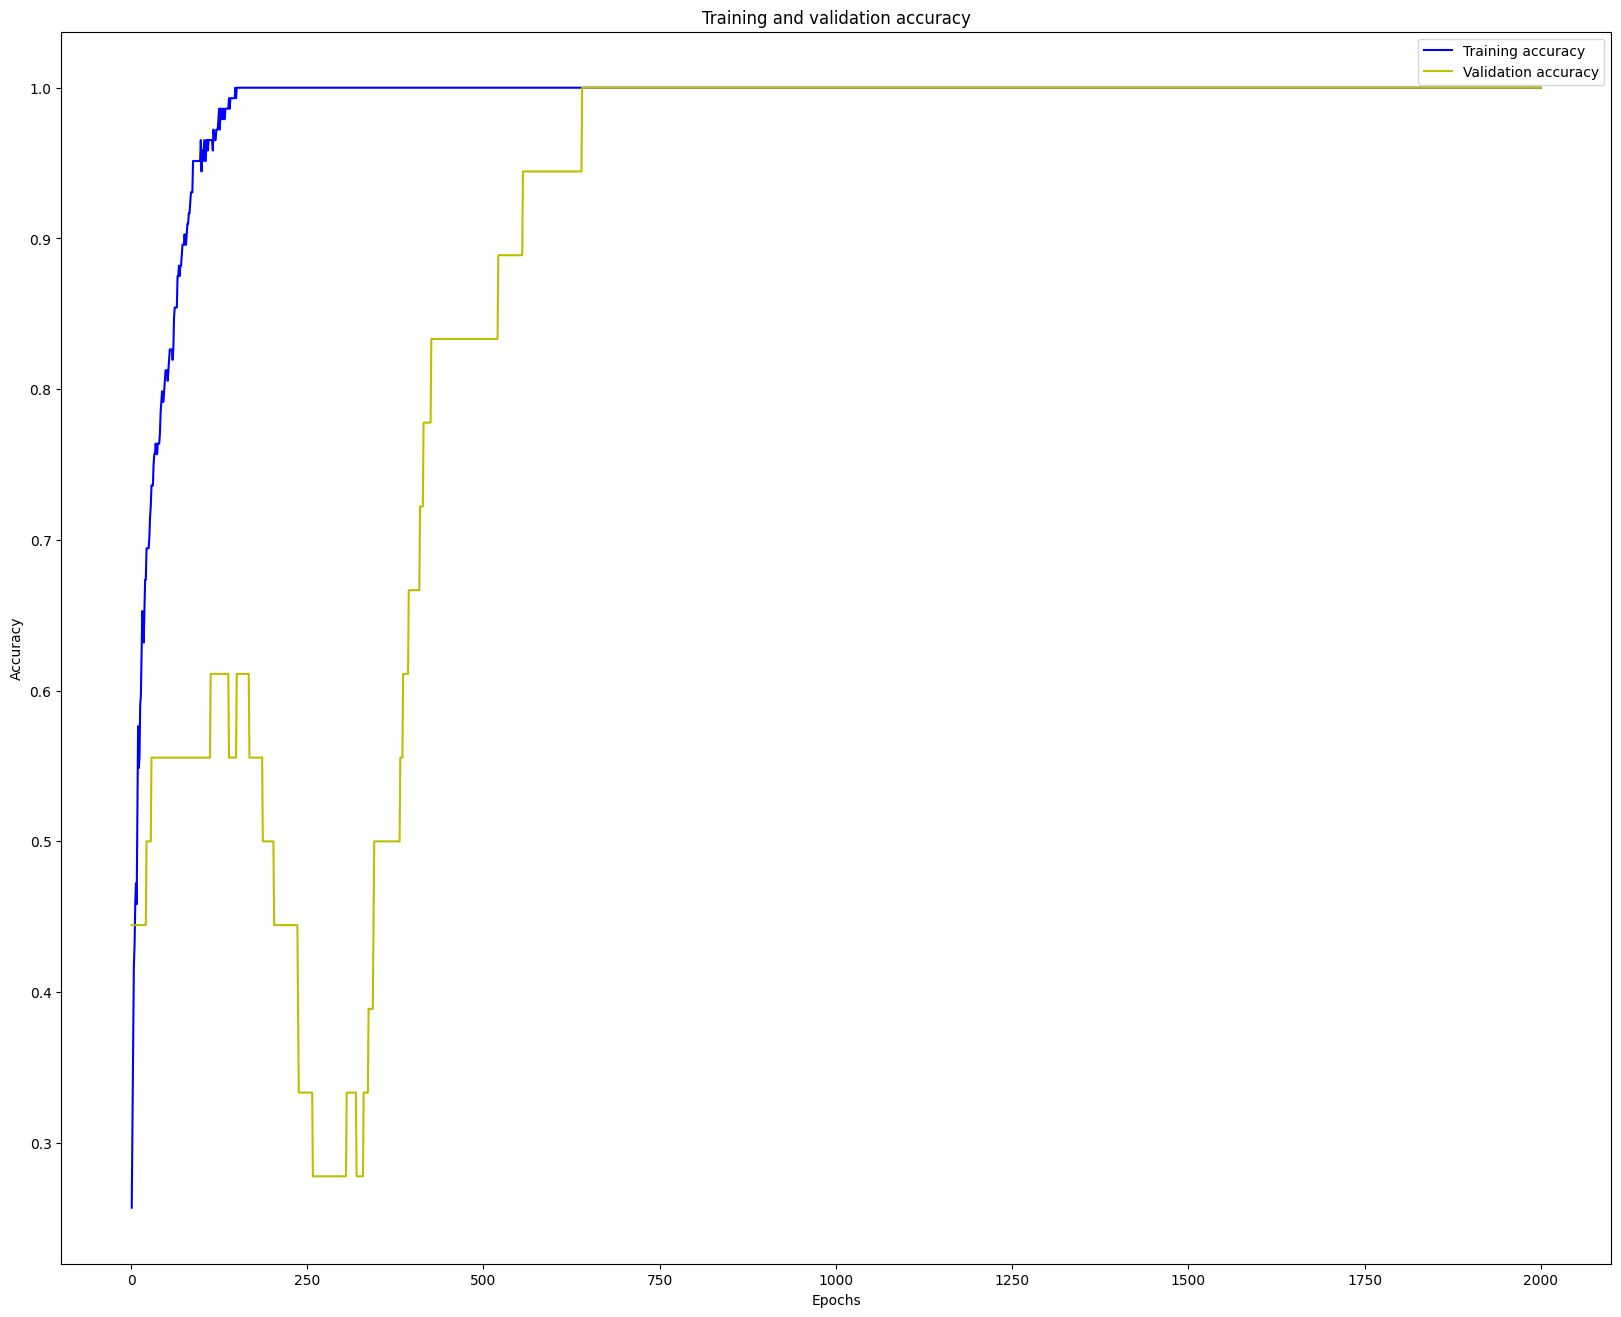

In [29]:
plt.figure(figsize=(20, 16))
plt.plot(epochs, acc, "b", label=  "Training accuracy")
plt.plot(epochs, val_acc, "y", label = "Validation accuracy")
plt.title("Training and validation accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

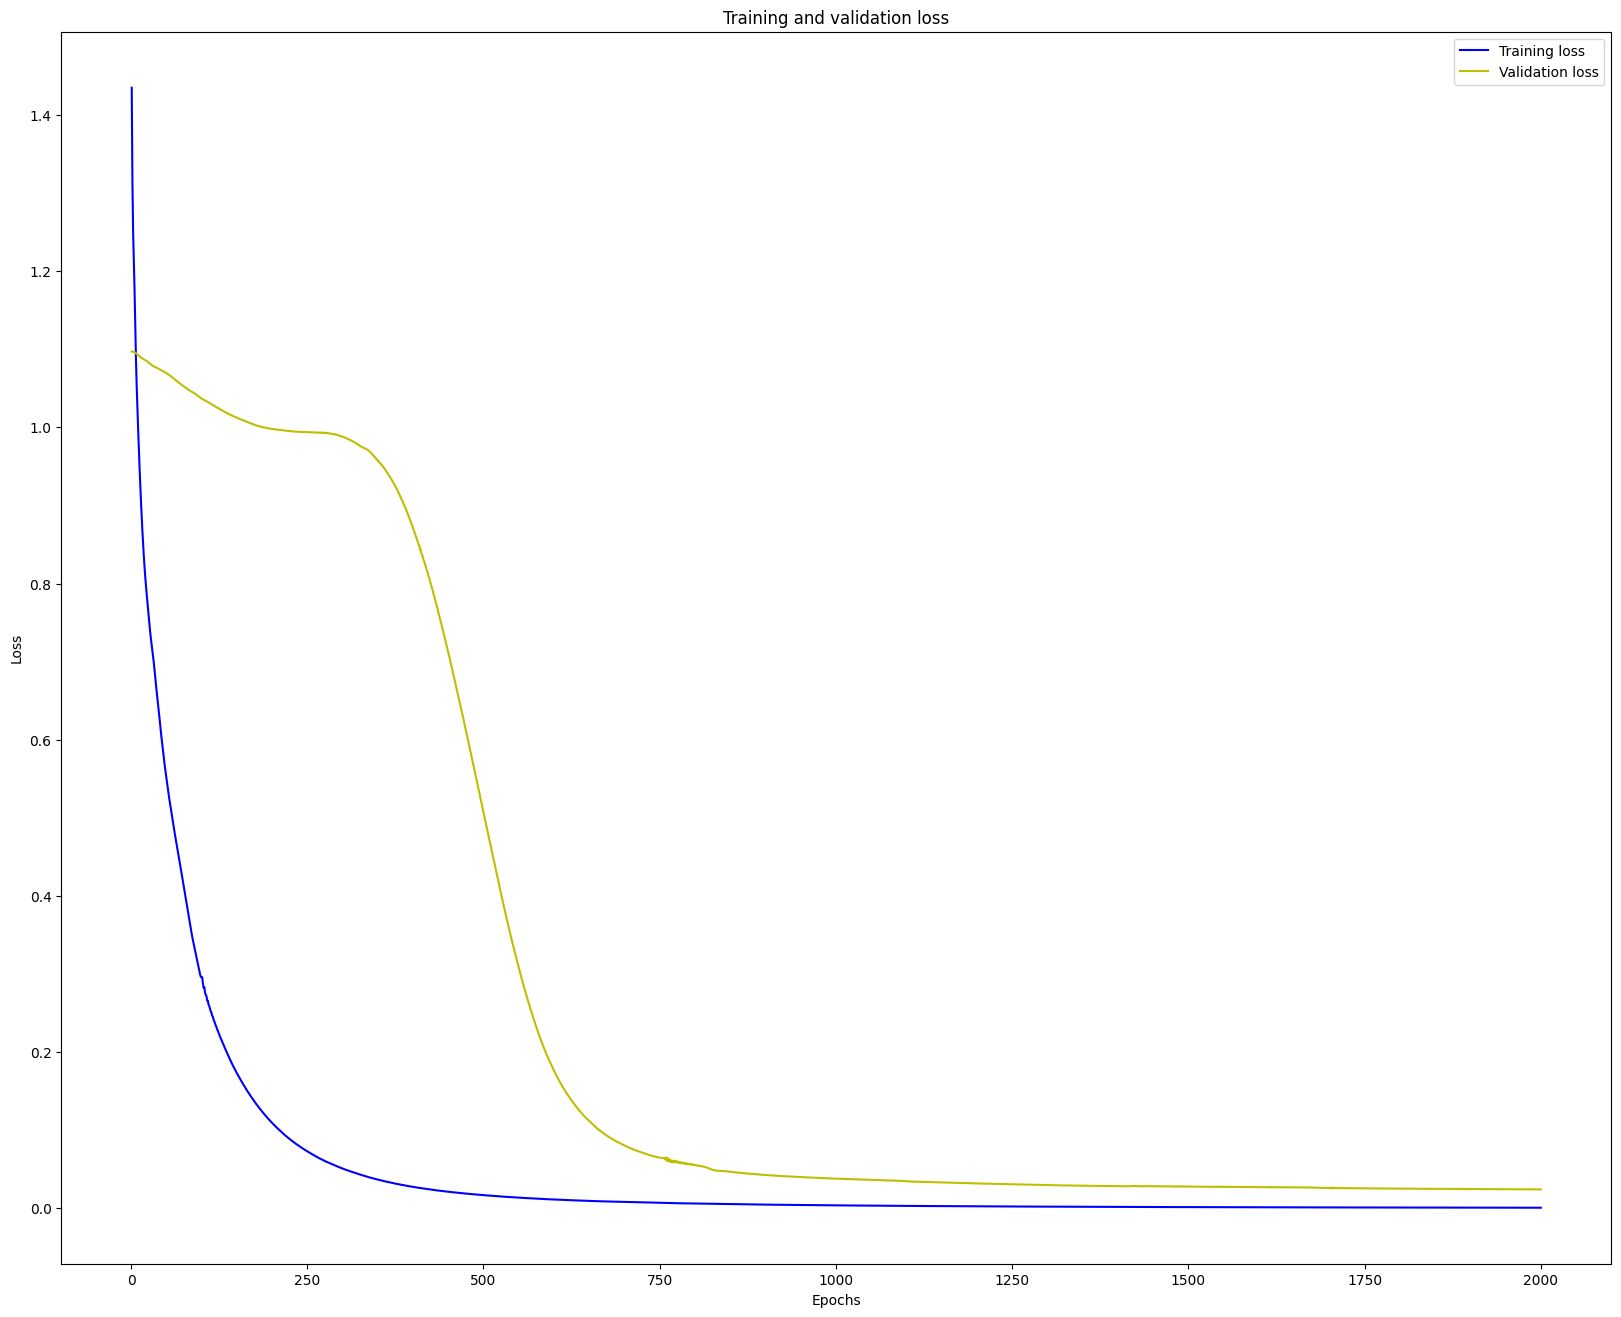

In [30]:
plt.figure(figsize=(20, 16))
plt.plot(epochs, loss, "b", label="Training loss")
plt.plot(epochs, val_loss, "y", label="Validation loss")
plt.title("Training and validation loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

In [31]:
print("Loss")
print(np.min(loss))
print(np.argmin(loss))
print("Validation Loss")
print(np.min(val_loss))
print(np.argmin(val_loss))
print("Accuracy")
print(np.max(acc))
print(np.argmax(acc))
print("Validation Accuracy")
print(np.max(val_acc))
print(np.argmax(val_acc))

Loss
0.0008535680826753378
1999
Validation Loss
0.02431478351354599
1999
Accuracy
1.0
147
Validation Accuracy
1.0
639


In [32]:
labels = list(test_targets)
predictions = list(np.argmax(model.predict(x_test), axis=1))
confusion_matrix = tf.math.confusion_matrix(labels, predictions)

1/1 [==============================] - 1s 697ms/step


In [33]:
print(labels)
print(predictions)

[2, 1, 1, 1, 0, 2, 0, 2, 2, 0, 1, 0, 0, 0, 1, 2, 1, 2]
[1, 1, 1, 1, 0, 2, 0, 1, 2, 0, 1, 0, 0, 0, 1, 2, 1, 2]


[Text(0.5, 1.0, 'Confusion Matrix of Overall Accuracy')]

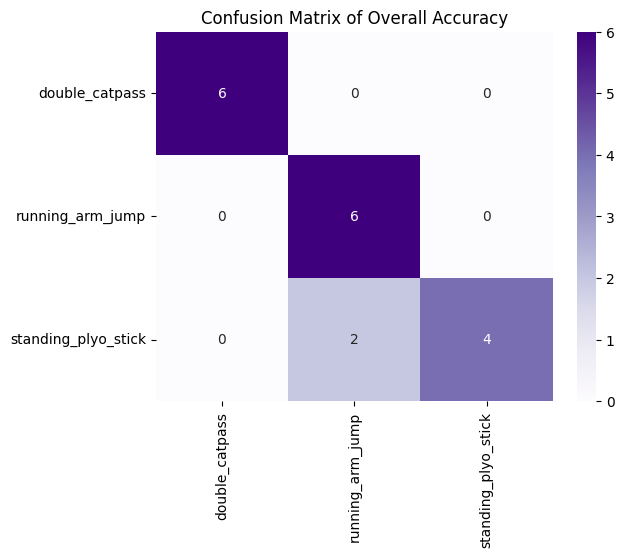

In [34]:
sns.heatmap(confusion_matrix, annot=True, cmap="Purples", xticklabels = class_names, yticklabels = class_names).set(title = "Confusion Matrix of Overall Accuracy")

### Rep Counter

In [35]:
print(type(shape))

<class 'list'>


In [36]:
def Rep_Counter(file_array, index, output_dir, log_output_filename):
    log = open(output_dir + log_output_filename, "a", encoding="utf-8")
    print("#############################################################", file=log)
    filename = Path(file_array[index])

    default_font = cv2.FONT_HERSHEY_SIMPLEX
    class_colours = [] 
    random.seed(seed)
    for i in class_names:
        B = random.randint(0, 255)
        G = random.randint(0, 255)
        R = random.randint(0, 255)
        colour = tuple([B, G, R])
        class_colours.append(colour)
        
    sequence = []
    logger = [] #sequential log, gives exact order
    predictions = []
    
    graph_data = [[] for i in range(0, number_of_classes)]
    
    threshold = 0.99
    count = 1
    cap = cv2.VideoCapture(file_array[index])
    width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
    height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
    fps = cap.get(cv2.CAP_PROP_FPS)
    fourcc = cv2.VideoWriter_fourcc(*"XVID")
    out = cv2.VideoWriter(output_dir + filename.name, fourcc, fps, (width, height))

    with mp_pose.Pose(min_detection_confidence=min_detect, min_tracking_confidence=min_track,
                      model_complexity = model_complex, enable_segmentation=segmentation) as pose:
        while cap.isOpened():
            number_of_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
            count += 1
            ret, frame = cap.read()

            if not ret:
                break

            exact_time_in_seconds = round(count/fps, 2)

            image, results = mediapipe_detection(frame, pose)
            keypoints = extract_keypoints(results)
            
            if keypoints is None:
                continue
            
            sequence.append(keypoints)
            sequence_np = np.array(sequence)
            sequence_np = scaler.fit_transform(sequence_np)
            sequence_np = pad_array(sequence_np, shape[1:])
            
            result = model.predict(np.expand_dims(sequence_np, axis=0))[0]
            
            for i in range(number_of_classes):
                graph_data[i].append(result[i])
            
            predicted_class_index = np.argmax(result) #0, 1, 2                 
            predicted_class_percentage = result[np.argmax(result)] #0.58%
            predicted_class_percentage_rounded = round(predicted_class_percentage, 2)
            predicted_class_name = class_names[np.argmax(result)] #catpass etc
            predictions.append(predicted_class_index)

            if np.unique(predictions[-10:])[0] == predicted_class_index: #checks last 10 frames have same value, might change
                if predicted_class_percentage > threshold:   
                    if len(logger) > 0:
                        if predicted_class_name != logger[-1][0]:
                            logger.append([predicted_class_name, exact_time_in_seconds, predicted_class_percentage_rounded])
                    else:
                        logger.append([predicted_class_name, exact_time_in_seconds, predicted_class_percentage_rounded])

            #This does the probability boxes for each class
            for class_index, probability in enumerate(result):
                start_point = (0, 60 + class_index * 40)
                end_point = (int(probability * 100), 90 + class_index * 40)
                colour = class_colours[class_index]
                thickness = -1
                cv2.rectangle(image, start_point, end_point, colour, thickness)

                text = "{}:{}%".format(class_names[class_index], int(probability*100))
                org = (0, 85 + class_index * 40)
                font_scale = 1
                colour = (255,255,255)
                thickness = 2
                line_type = cv2.LINE_AA
                cv2.putText(image, text, org, default_font, font_scale, colour, thickness, line_type)
            

            move_count_array = [0] * len(class_names)
            if len(logger) > 0:
                for log_value in logger: #pair e.g. catpass, 0.01 seconds, 98%
                    index_to_increment = label_map.get(log_value[0])
                    move_count_array[index_to_increment] += 1

            text = "{}".format(logger)
            org = (3, 30)
            font_scale = 0.6
            colour = (255,255,255)
            thickness = 2
            line_type = cv2.LINE_AA
            cv2.putText(image, text, org, default_font, font_scale, colour, thickness, line_type)
            cv2.imshow("Rep-Tracker", image)
            out.write(image)
            if cv2.waitKey(10) & 0xFF == ord("q"):
                break
        count_array = [predictions.count(i) for i in range(len(class_names))]
        
        print("Video {}, {}".format(index+1,filename.name), file=log)
        print("###Repetiton Counter###", file=log)
        for i in range(len(class_names)):
            print("{}={}".format(class_names[i], move_count_array[i]), file=log)
            
        print("###Frames###", file=log)
        for i in range(len(class_names)):
            print("{}={}".format(class_names[i], count_array[i]), file=log)
        
        print("###Logger###", file=log)
        print(str(logger), file=log)
            
        print("Readable Frames: {}/{}".format(len(graph_data[0]),number_of_frames), file=log)
        print("Estimate: \"{}\" with {}/{} frames.".format(class_names[np.argmax(count_array)], np.max(count_array),number_of_frames), file=log)
        cap.release()
        out.release()
        cv2.destroyAllWindows()

    plt.figure(figsize=(20, 16))    
    for i in range(number_of_classes):
        plt.plot(graph_data[i], label=class_names[i])
        
    plt.title("Graph for {}".format(filename.name))
    plt.xlabel("Frame Number")
    plt.ylabel("Accuracy")
    plt.legend()
    plt.savefig(output_dir+filename.stem)
    return np.argmax(count_array)

In [37]:
def rep_counter_accuracy(file_list, log_output_filename):
    results = []
    output = os.getcwd() + r"/results/"
    
    if not os.path.exists(output):
        os.mkdir(output)
    
    for index in range(len(file_list)):
        results.append(Rep_Counter(test_files, index, output, log_output_filename))
    return results 

In [38]:
def similarity(labels, outputs):
    count = 0
    for index in range(len(labels)):
        if labels[index] == outputs[index]:
            count += 1
    return (count/len(labels))*100

### Rep Counter Testing

1/1 [==============================] - 0s 44ms/step


OpenCV: FFMPEG: tag 0x44495658/'XVID' is not supported with codec id 12 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x7634706d/'mp4v'


1/1 [==============================] - 0s 19ms/step


OpenCV: FFMPEG: tag 0x44495658/'XVID' is not supported with codec id 12 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x7634706d/'mp4v'


1/1 [==============================] - 0s 20ms/step


OpenCV: FFMPEG: tag 0x44495658/'XVID' is not supported with codec id 12 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x7634706d/'mp4v'


1/1 [==============================] - 0s 19ms/step


OpenCV: FFMPEG: tag 0x44495658/'XVID' is not supported with codec id 12 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x7634706d/'mp4v'


1/1 [==============================] - 0s 21ms/step


OpenCV: FFMPEG: tag 0x44495658/'XVID' is not supported with codec id 12 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x7634706d/'mp4v'


1/1 [==============================] - 0s 19ms/step


OpenCV: FFMPEG: tag 0x44495658/'XVID' is not supported with codec id 12 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x7634706d/'mp4v'


1/1 [==============================] - 0s 19ms/step


OpenCV: FFMPEG: tag 0x44495658/'XVID' is not supported with codec id 12 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x7634706d/'mp4v'


1/1 [==============================] - 0s 20ms/step


OpenCV: FFMPEG: tag 0x44495658/'XVID' is not supported with codec id 12 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x7634706d/'mp4v'


1/1 [==============================] - 0s 20ms/step


OpenCV: FFMPEG: tag 0x44495658/'XVID' is not supported with codec id 12 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x7634706d/'mp4v'


1/1 [==============================] - 0s 19ms/step


OpenCV: FFMPEG: tag 0x44495658/'XVID' is not supported with codec id 12 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x7634706d/'mp4v'


1/1 [==============================] - 0s 19ms/step


OpenCV: FFMPEG: tag 0x44495658/'XVID' is not supported with codec id 12 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x7634706d/'mp4v'


1/1 [==============================] - 0s 19ms/step


OpenCV: FFMPEG: tag 0x44495658/'XVID' is not supported with codec id 12 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x7634706d/'mp4v'


1/1 [==============================] - 0s 19ms/step


OpenCV: FFMPEG: tag 0x44495658/'XVID' is not supported with codec id 12 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x7634706d/'mp4v'


1/1 [==============================] - 0s 20ms/step


OpenCV: FFMPEG: tag 0x44495658/'XVID' is not supported with codec id 12 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x7634706d/'mp4v'


1/1 [==============================] - 0s 20ms/step


OpenCV: FFMPEG: tag 0x44495658/'XVID' is not supported with codec id 12 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x7634706d/'mp4v'


1/1 [==============================] - 0s 20ms/step


OpenCV: FFMPEG: tag 0x44495658/'XVID' is not supported with codec id 12 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x7634706d/'mp4v'


1/1 [==============================] - 0s 21ms/step


OpenCV: FFMPEG: tag 0x44495658/'XVID' is not supported with codec id 12 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x7634706d/'mp4v'


1/1 [==============================] - 0s 19ms/step


OpenCV: FFMPEG: tag 0x44495658/'XVID' is not supported with codec id 12 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x7634706d/'mp4v'


1/1 [==============================] - 0s 21ms/step


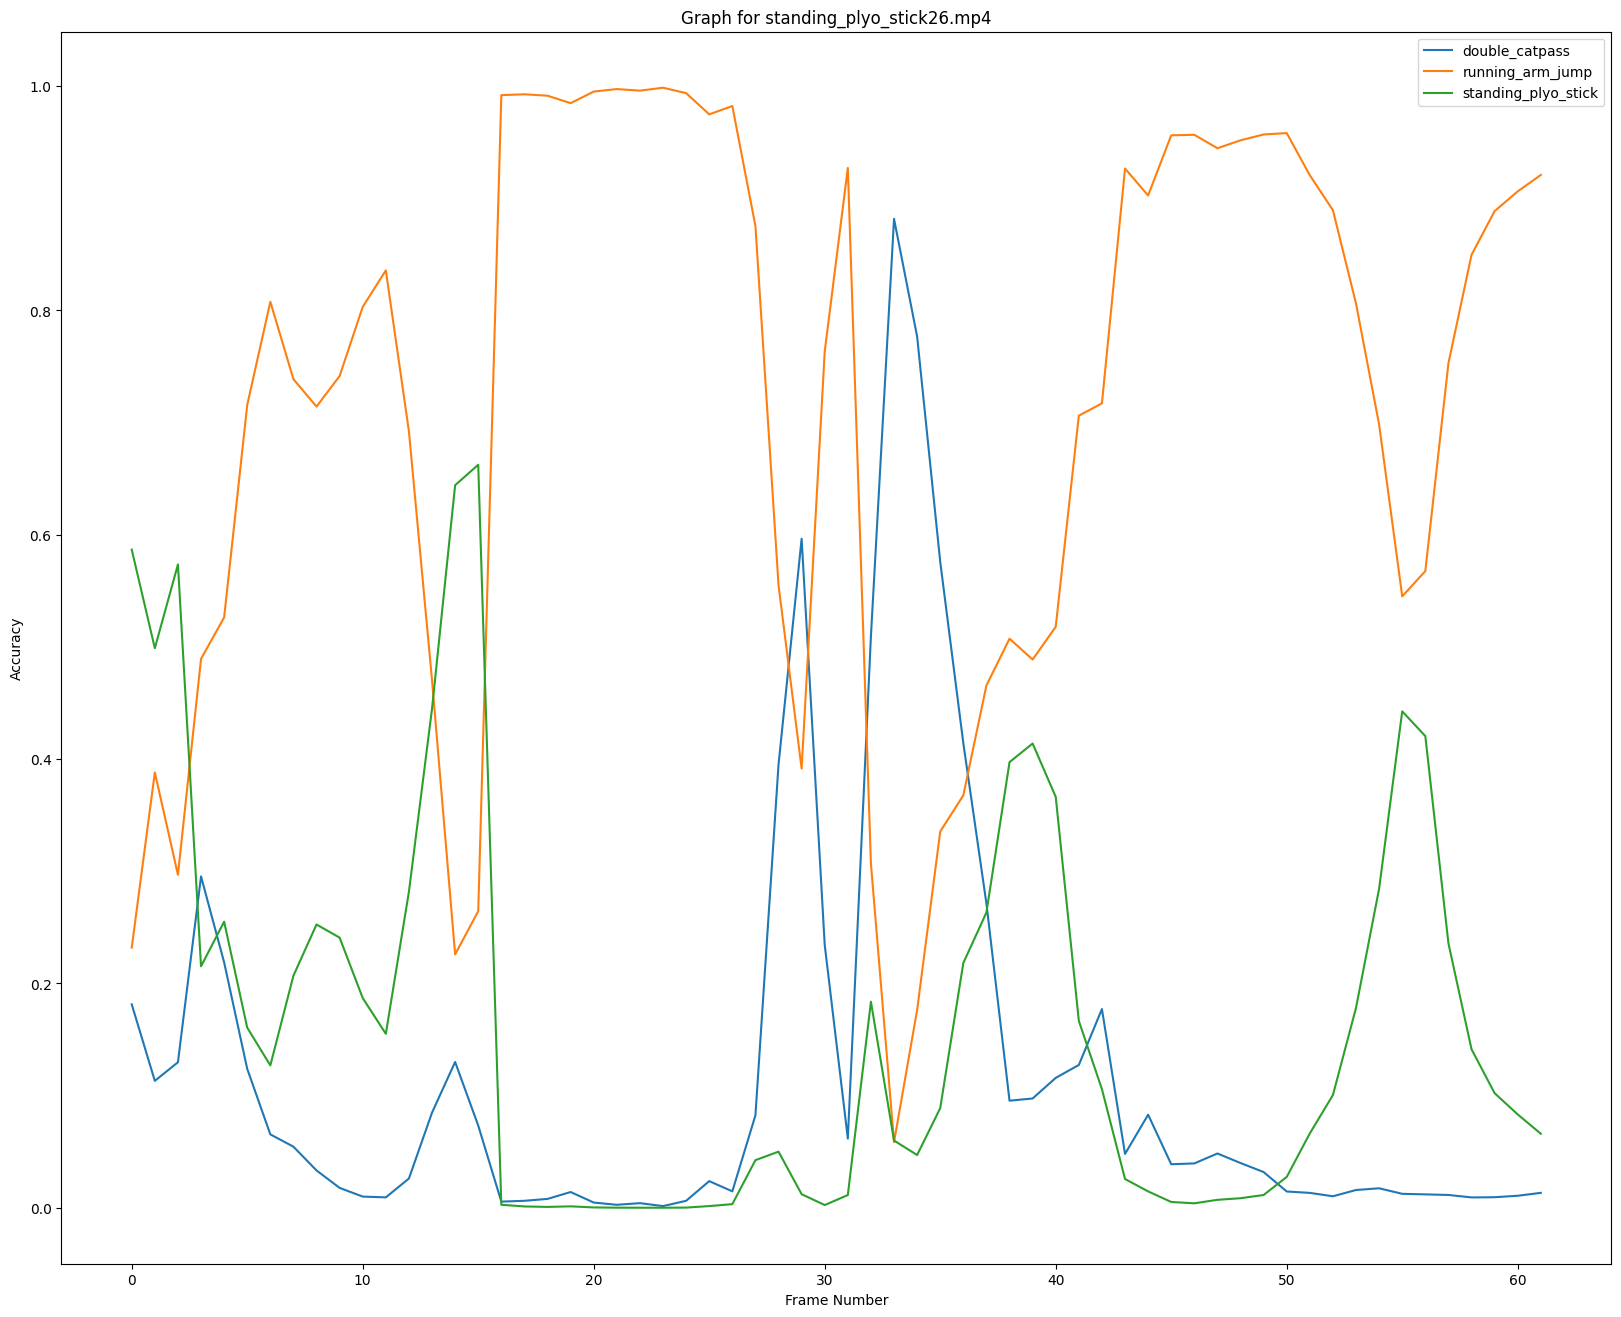

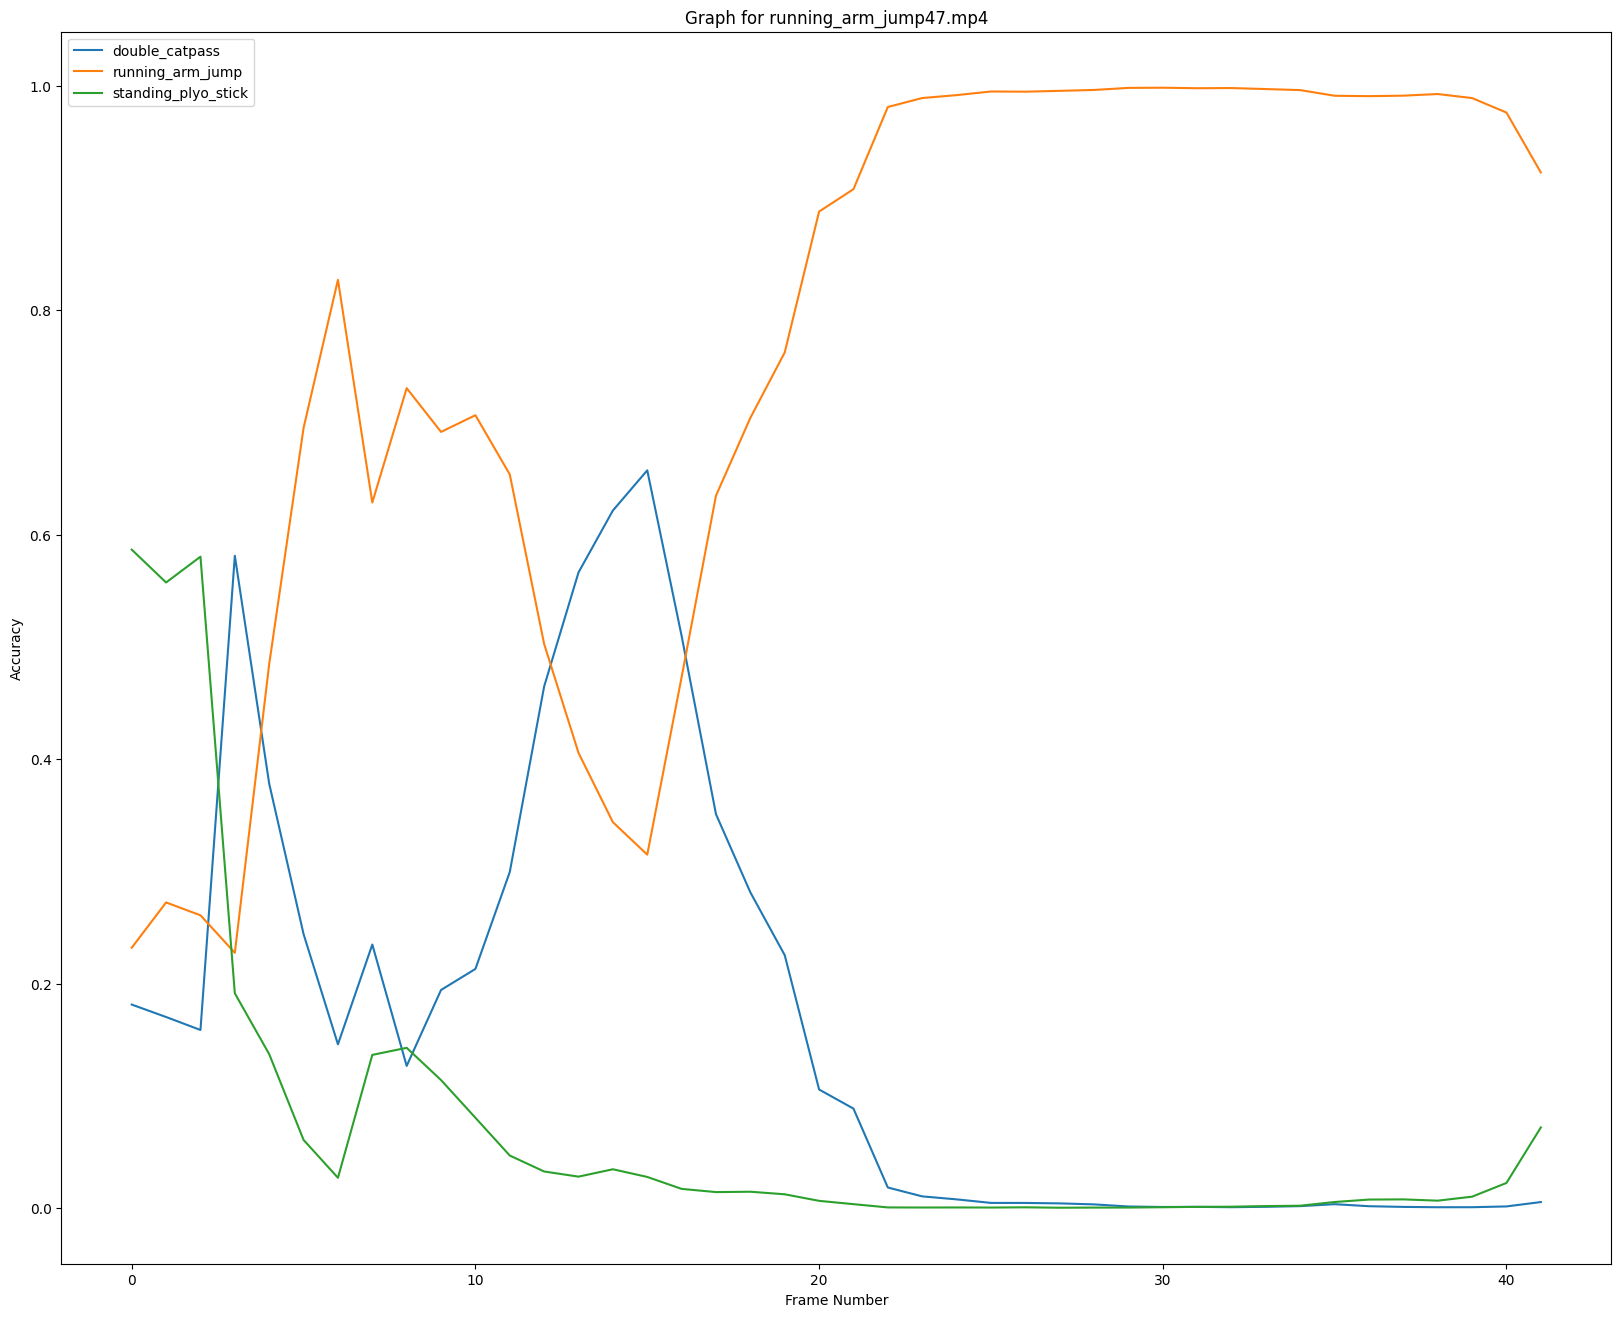

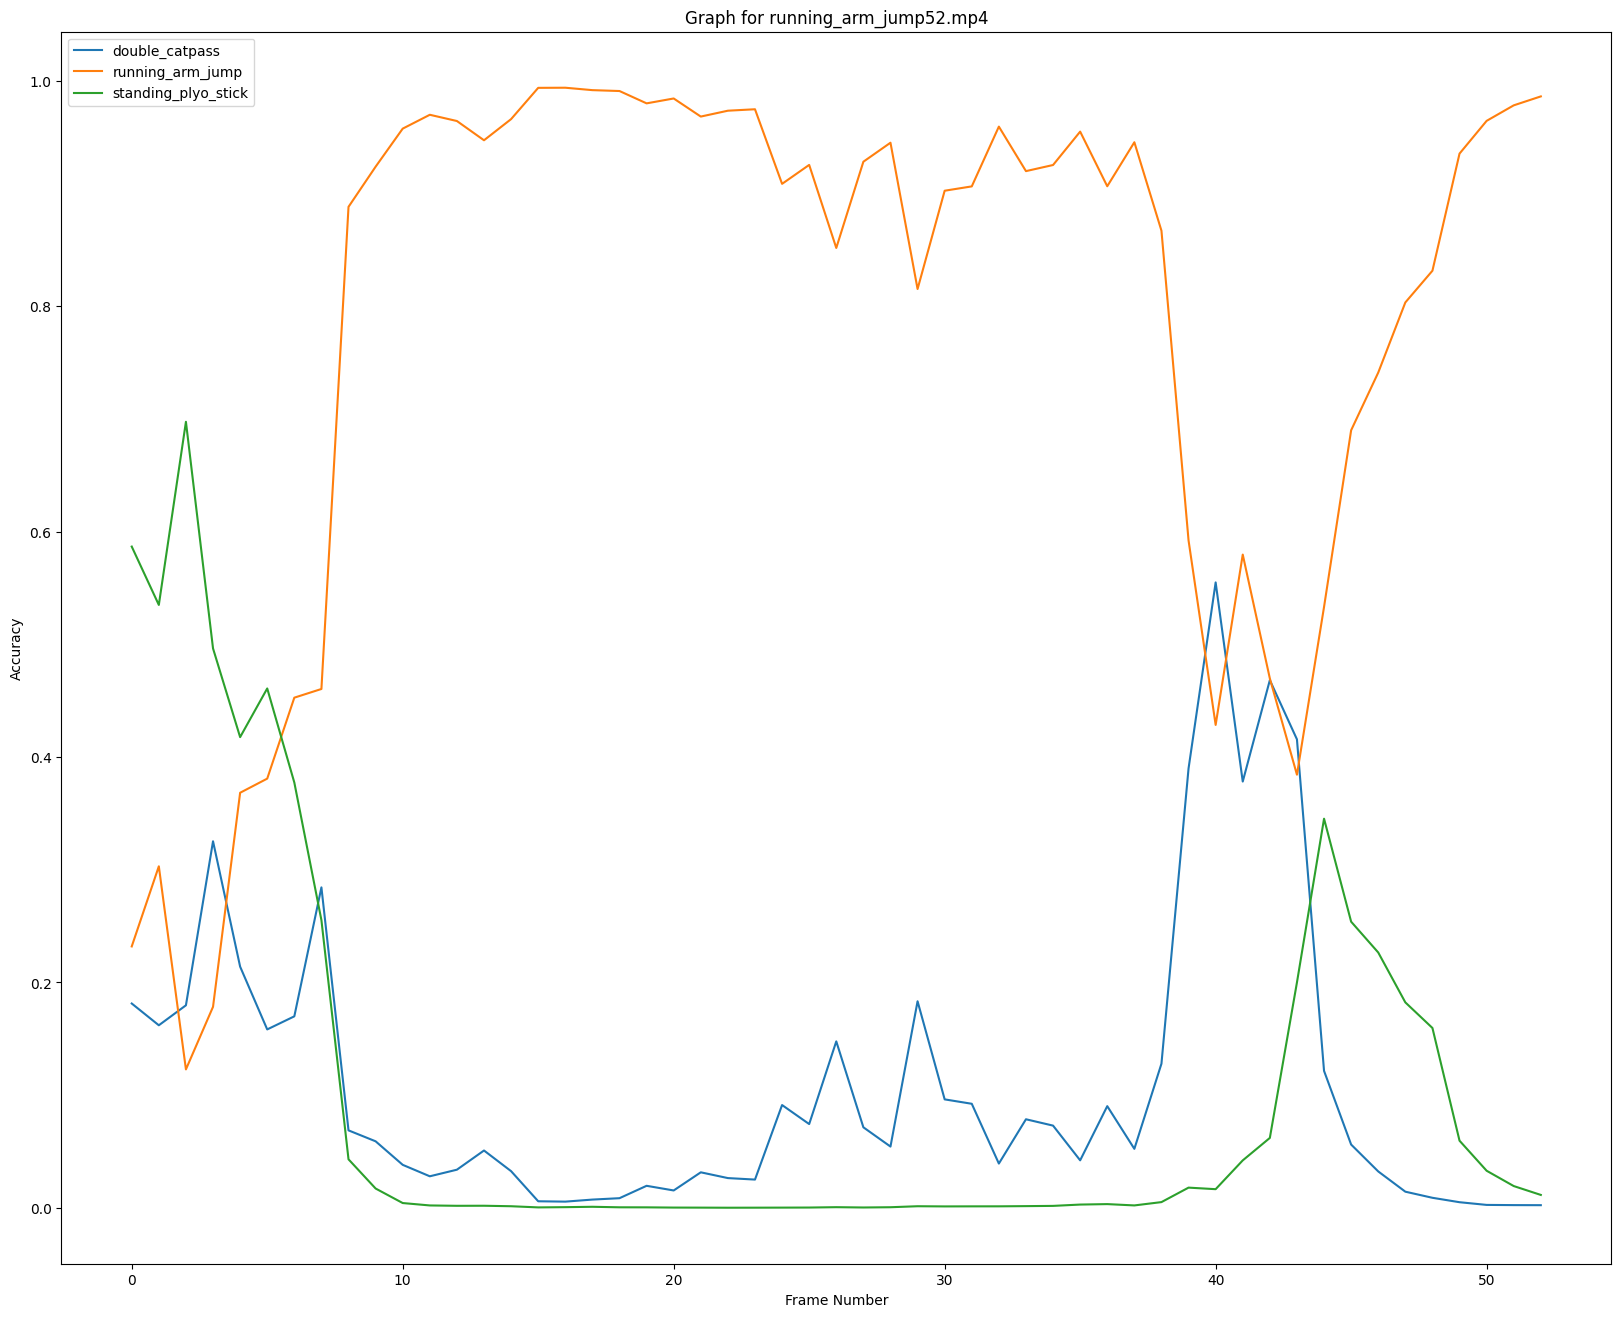

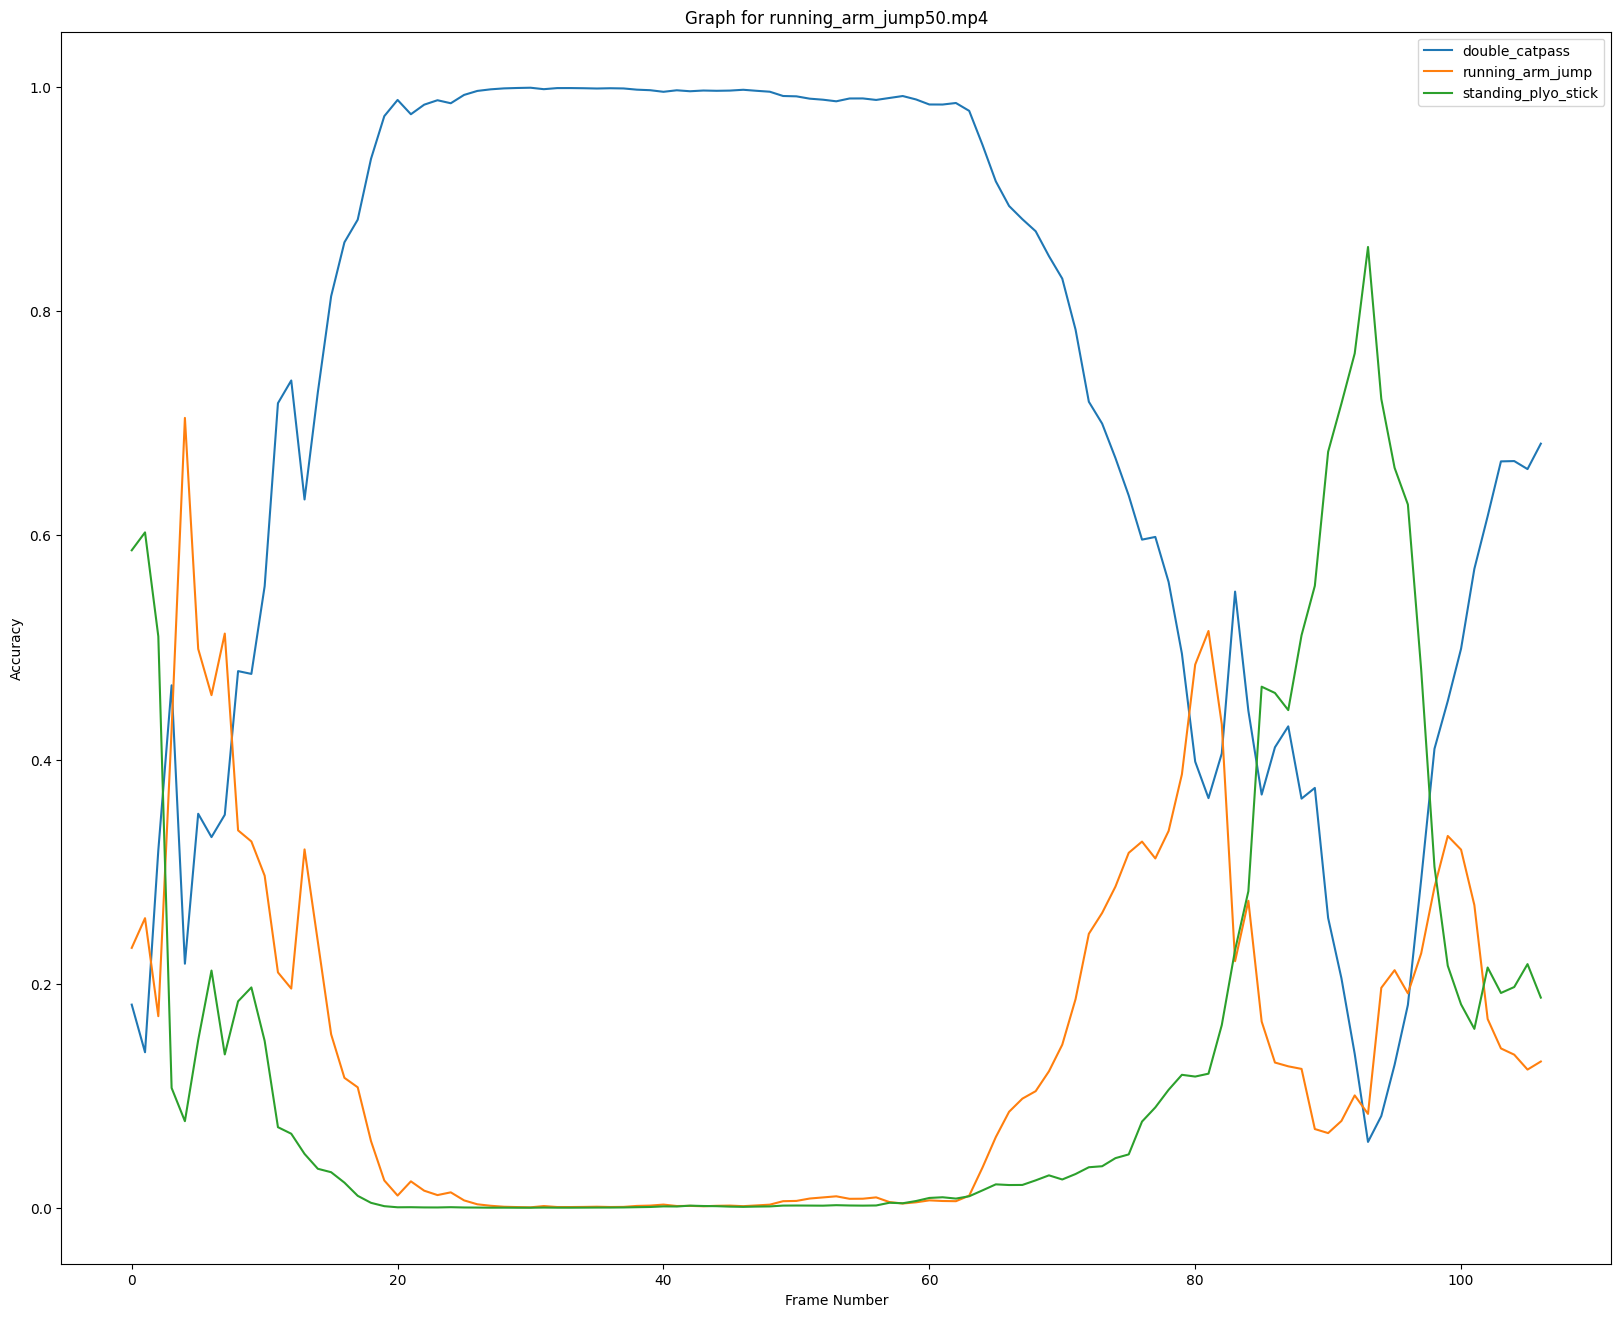

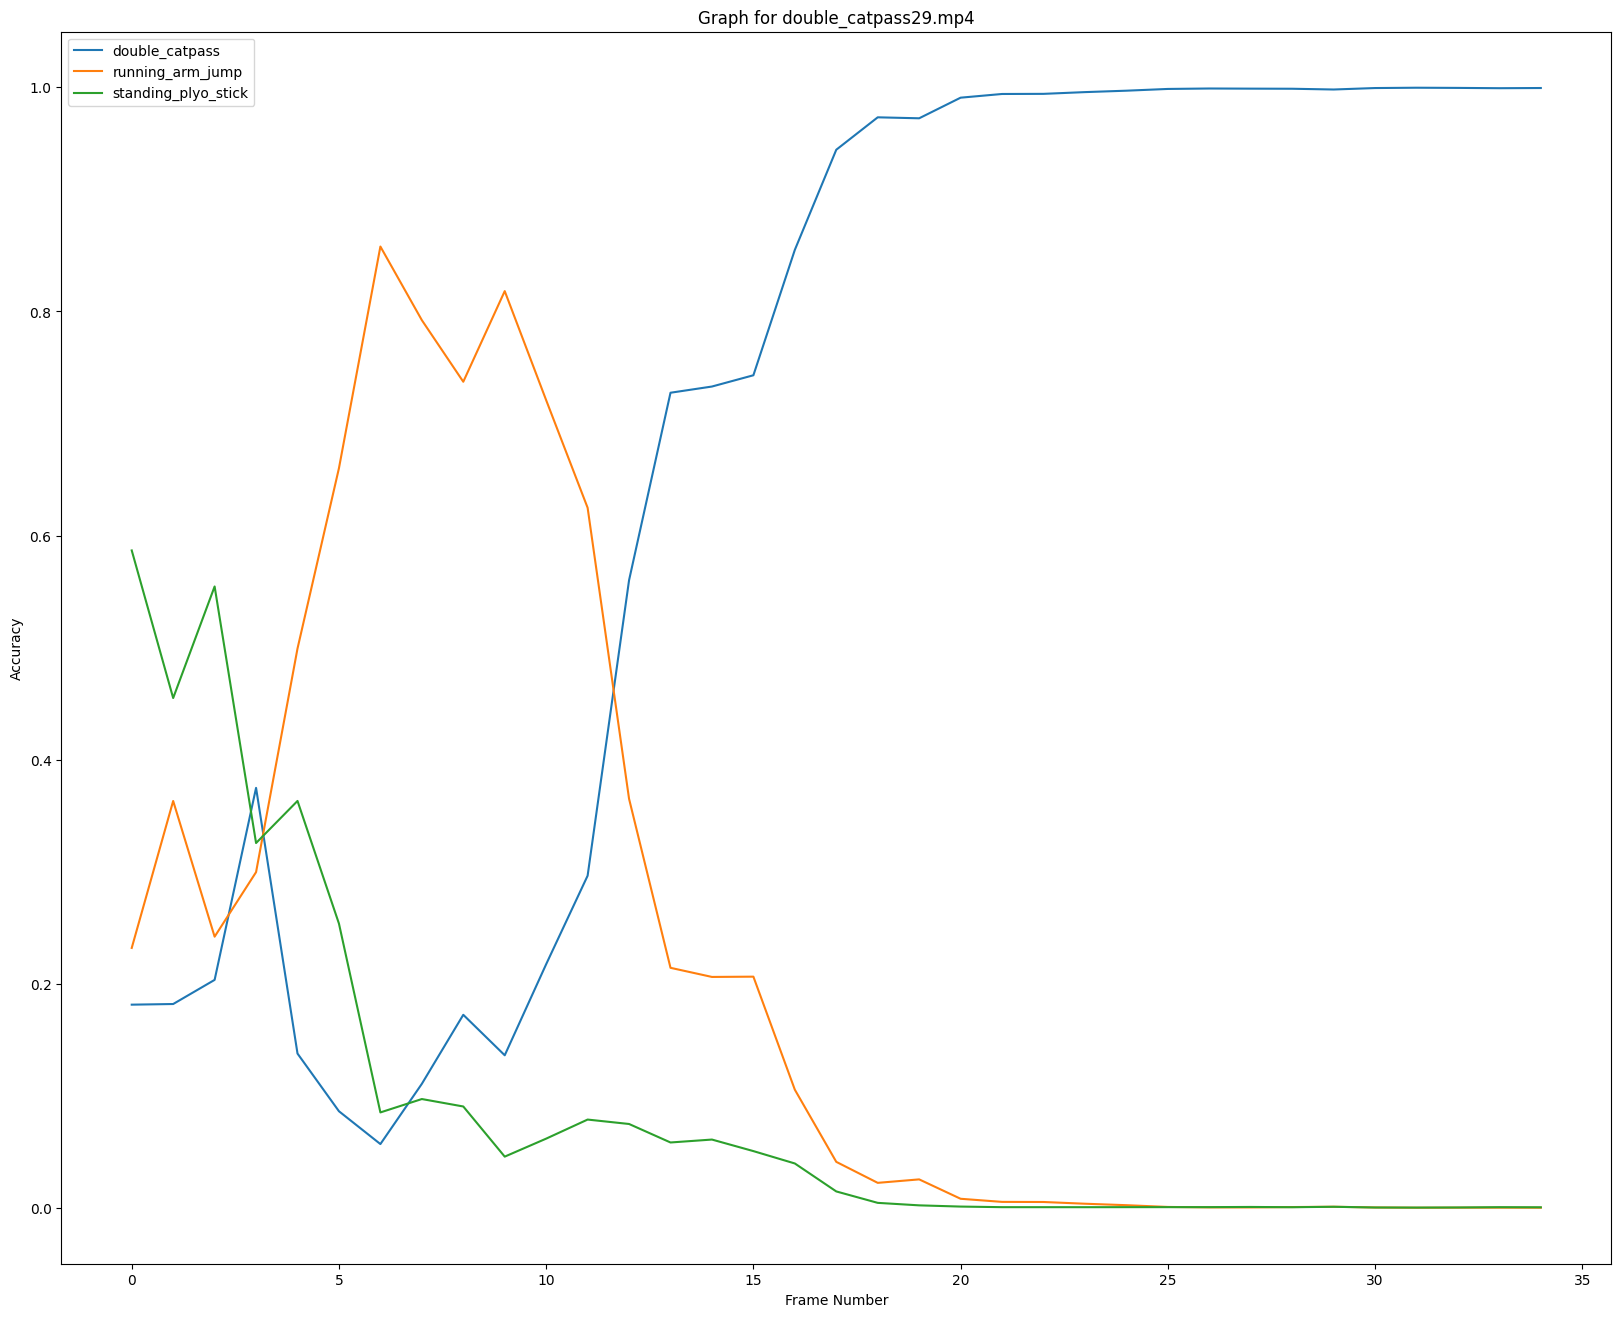

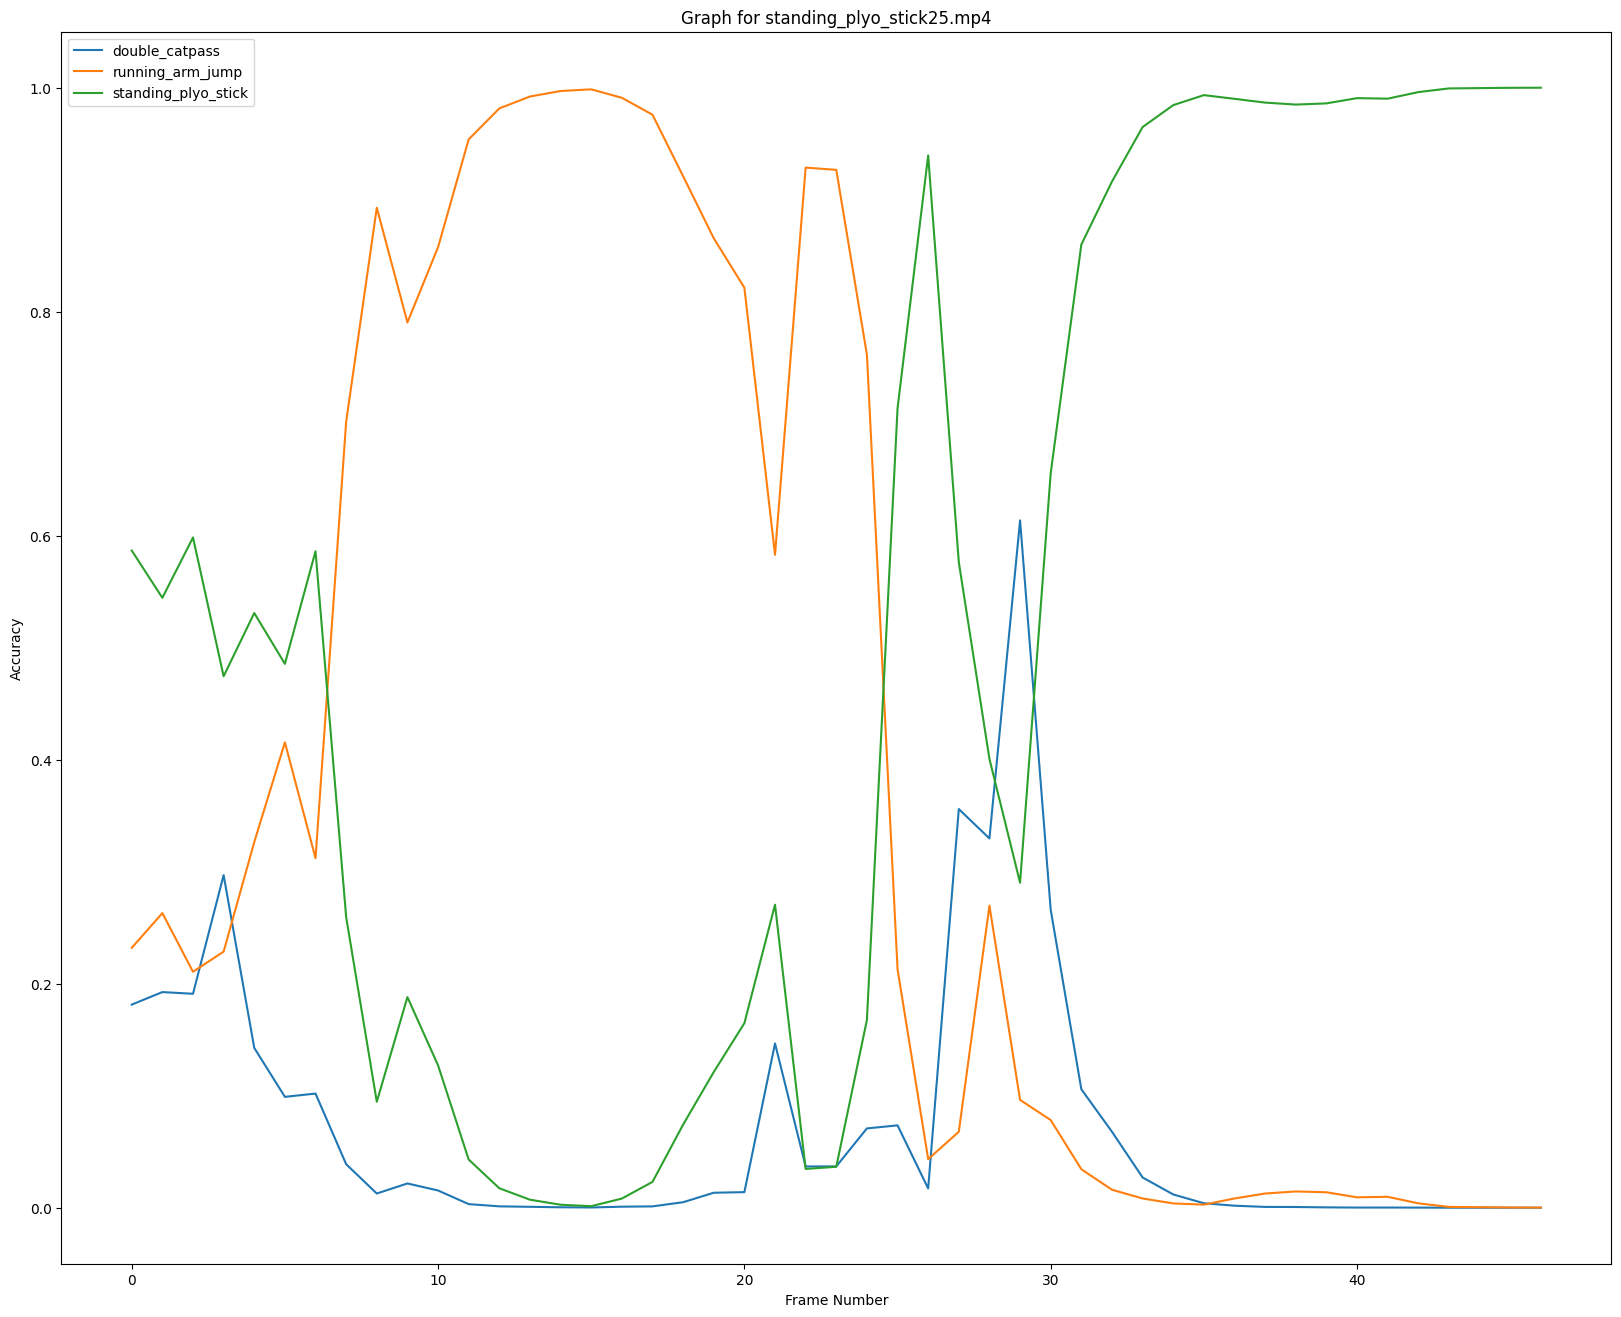

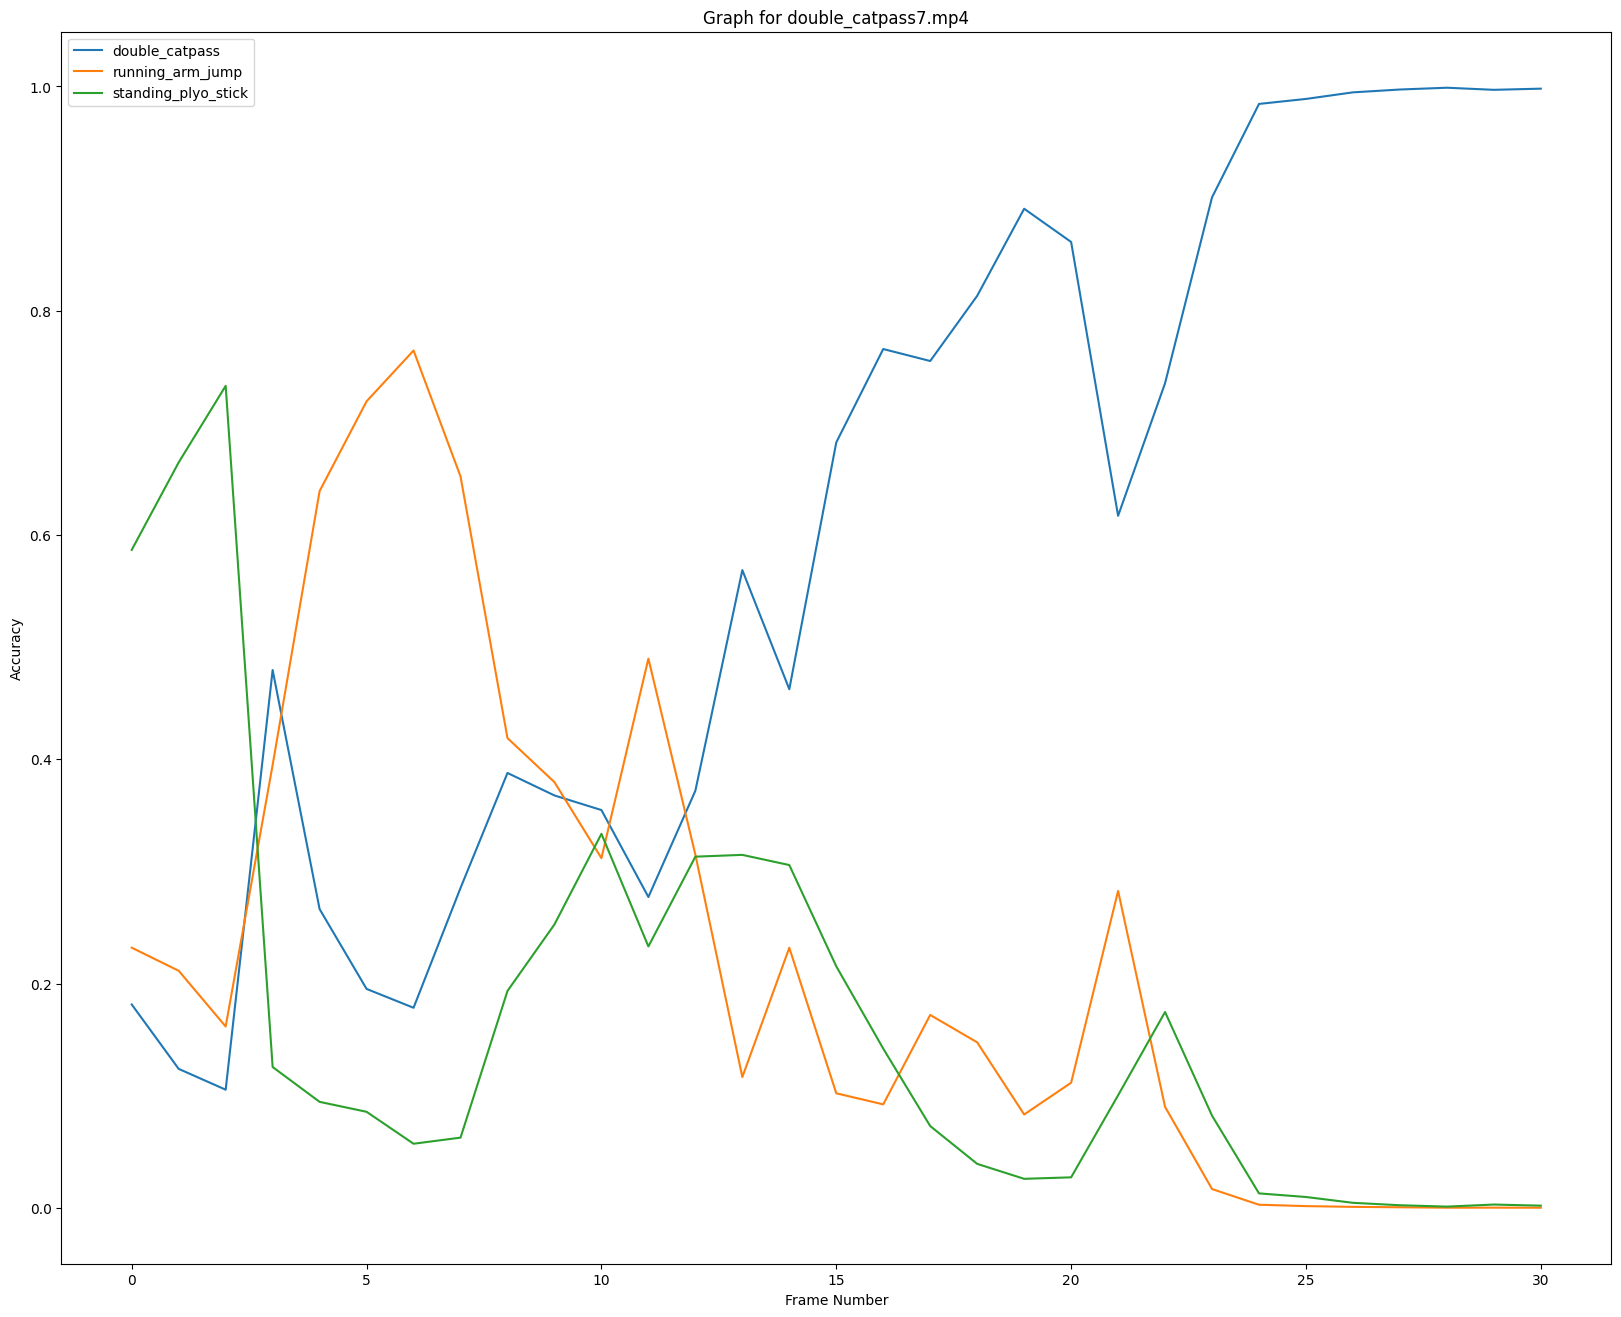

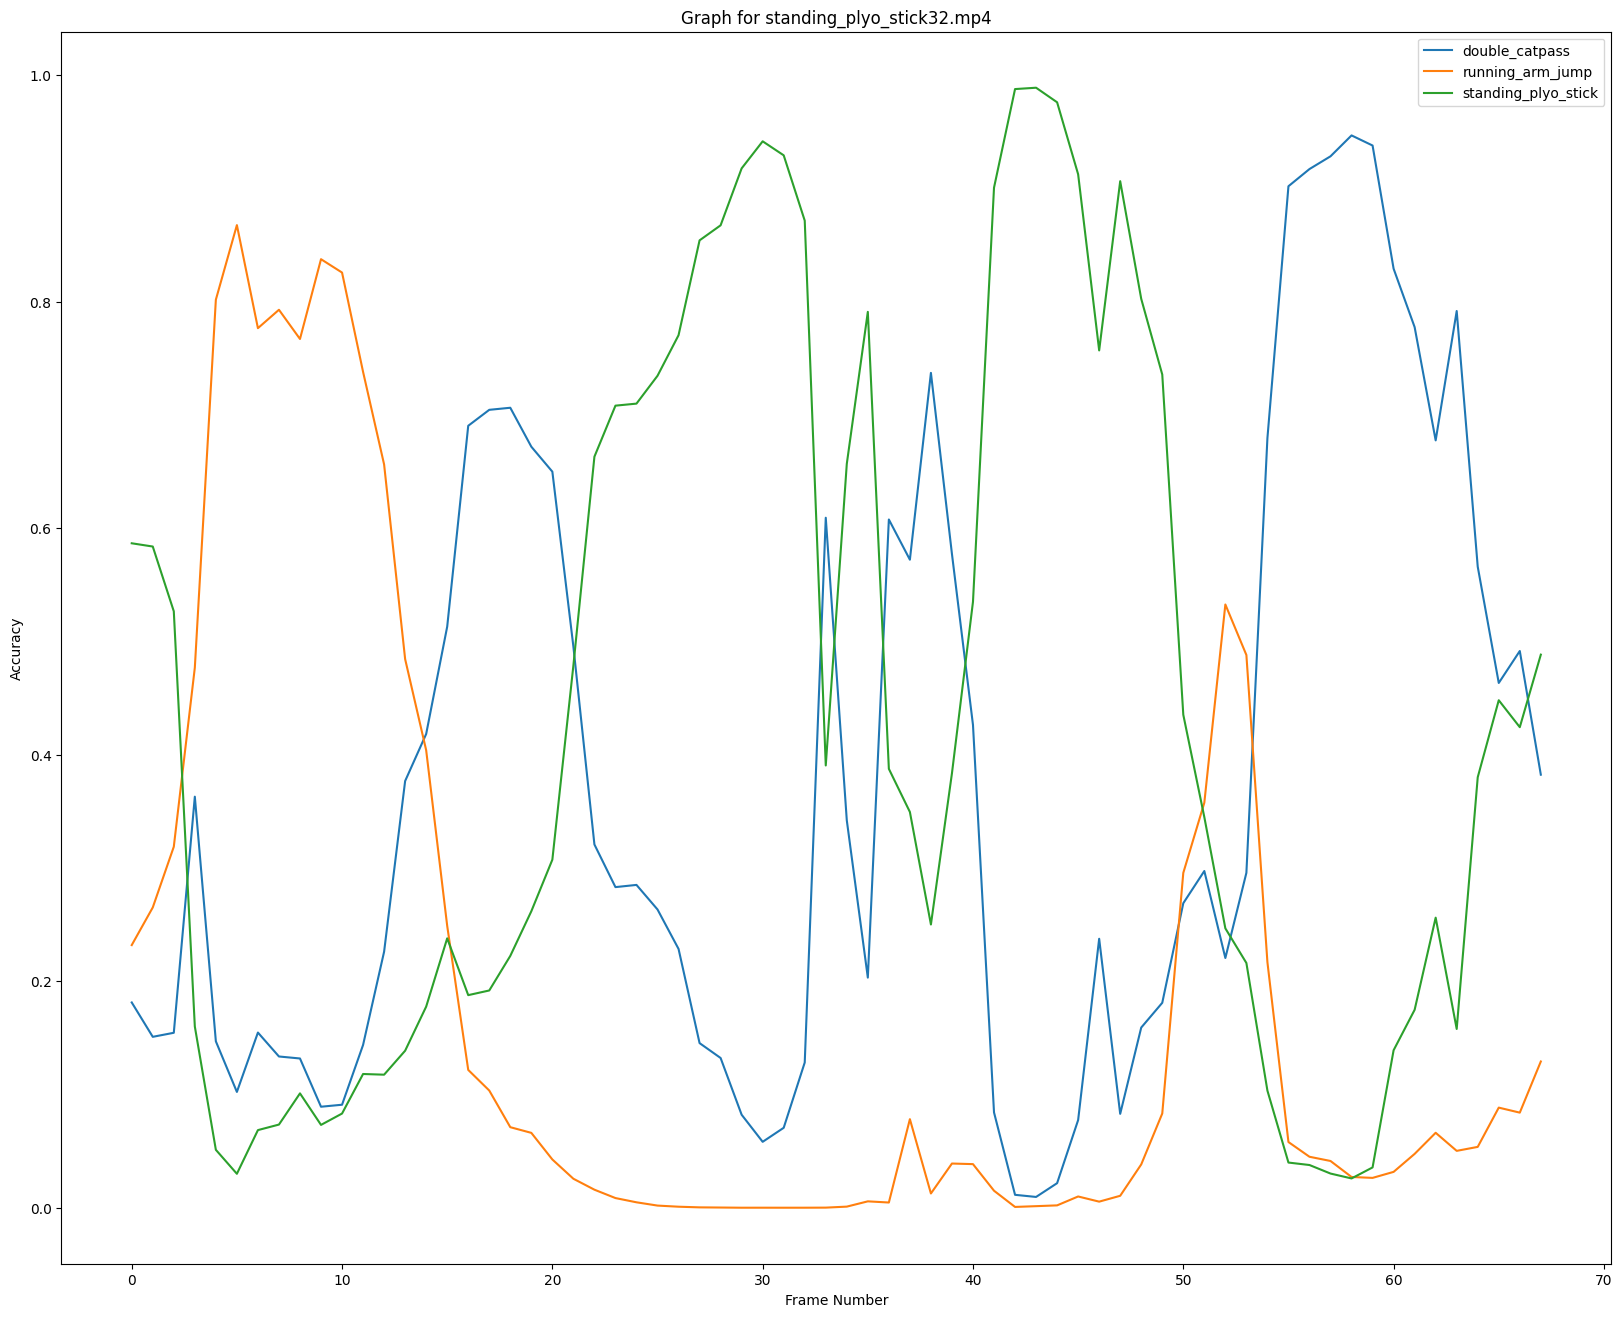

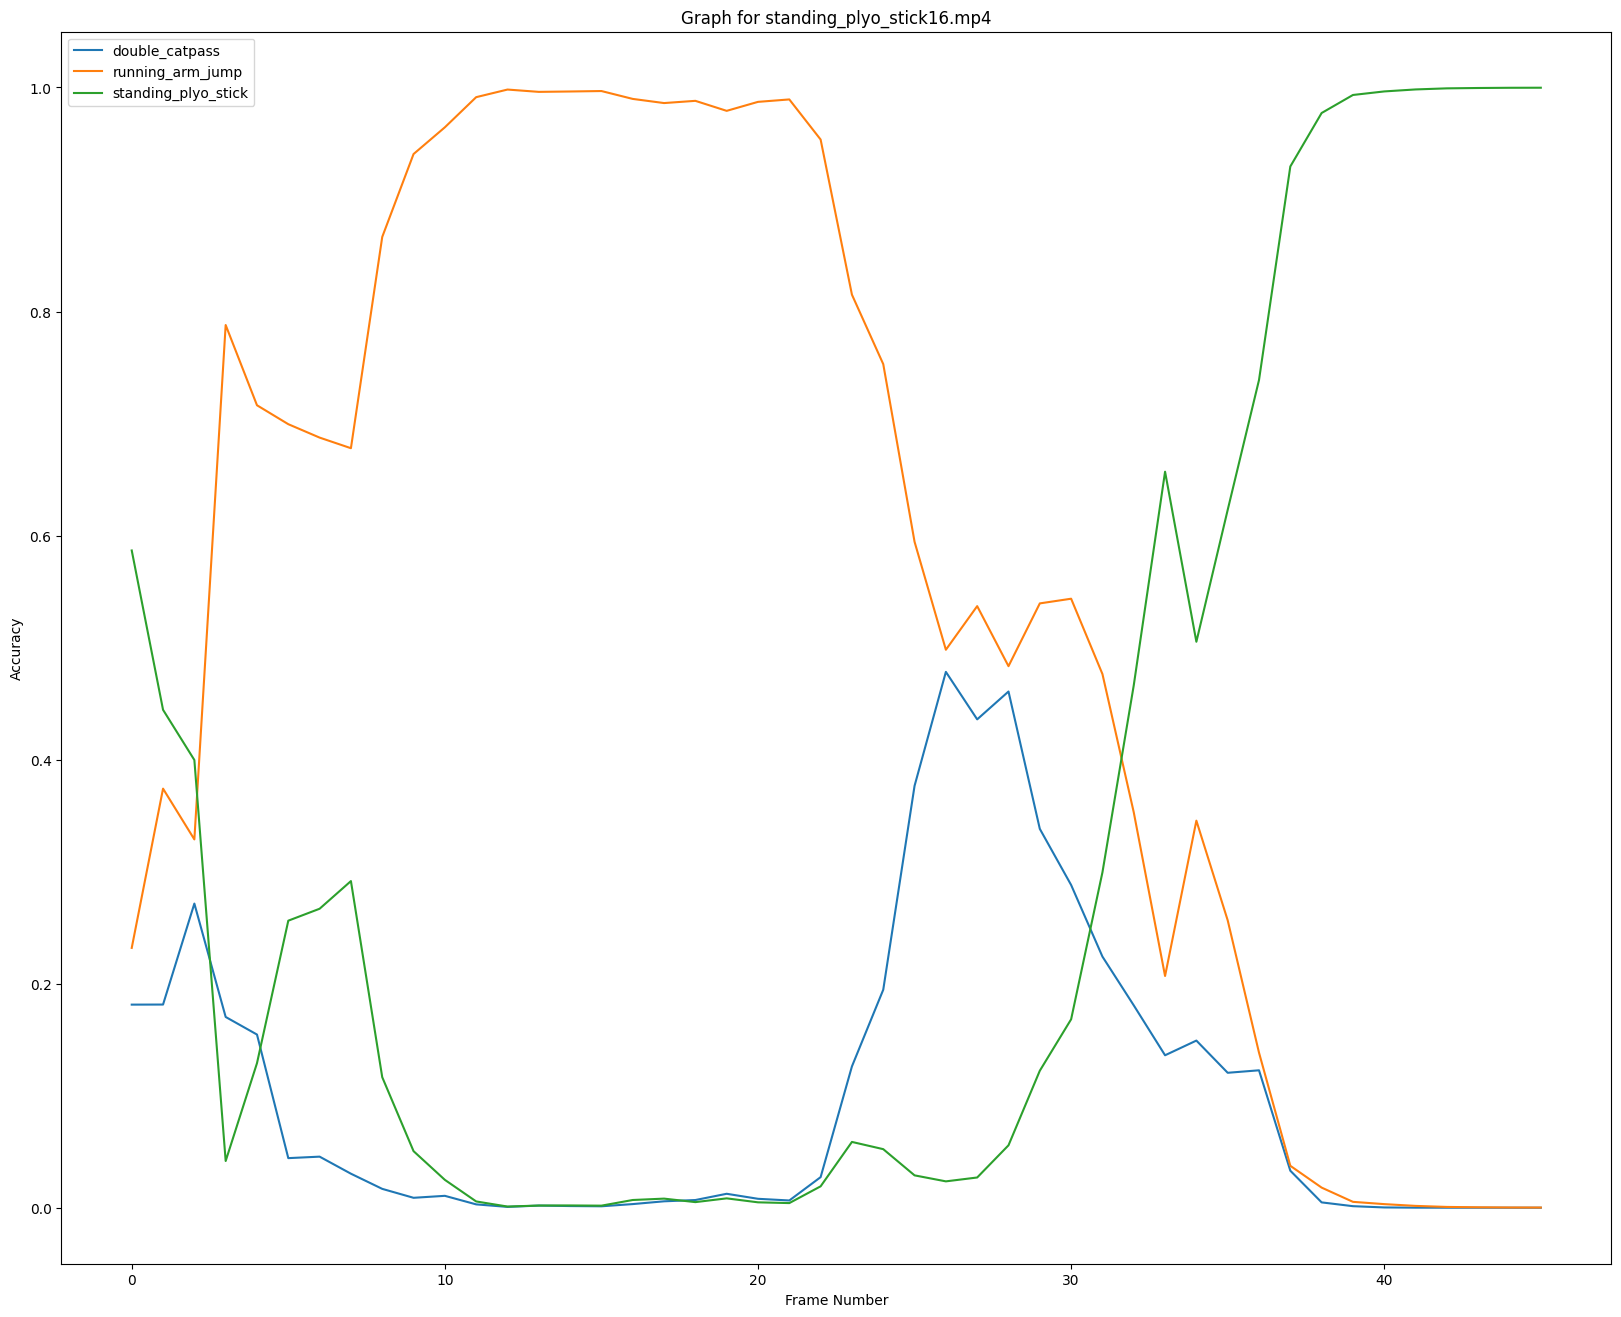

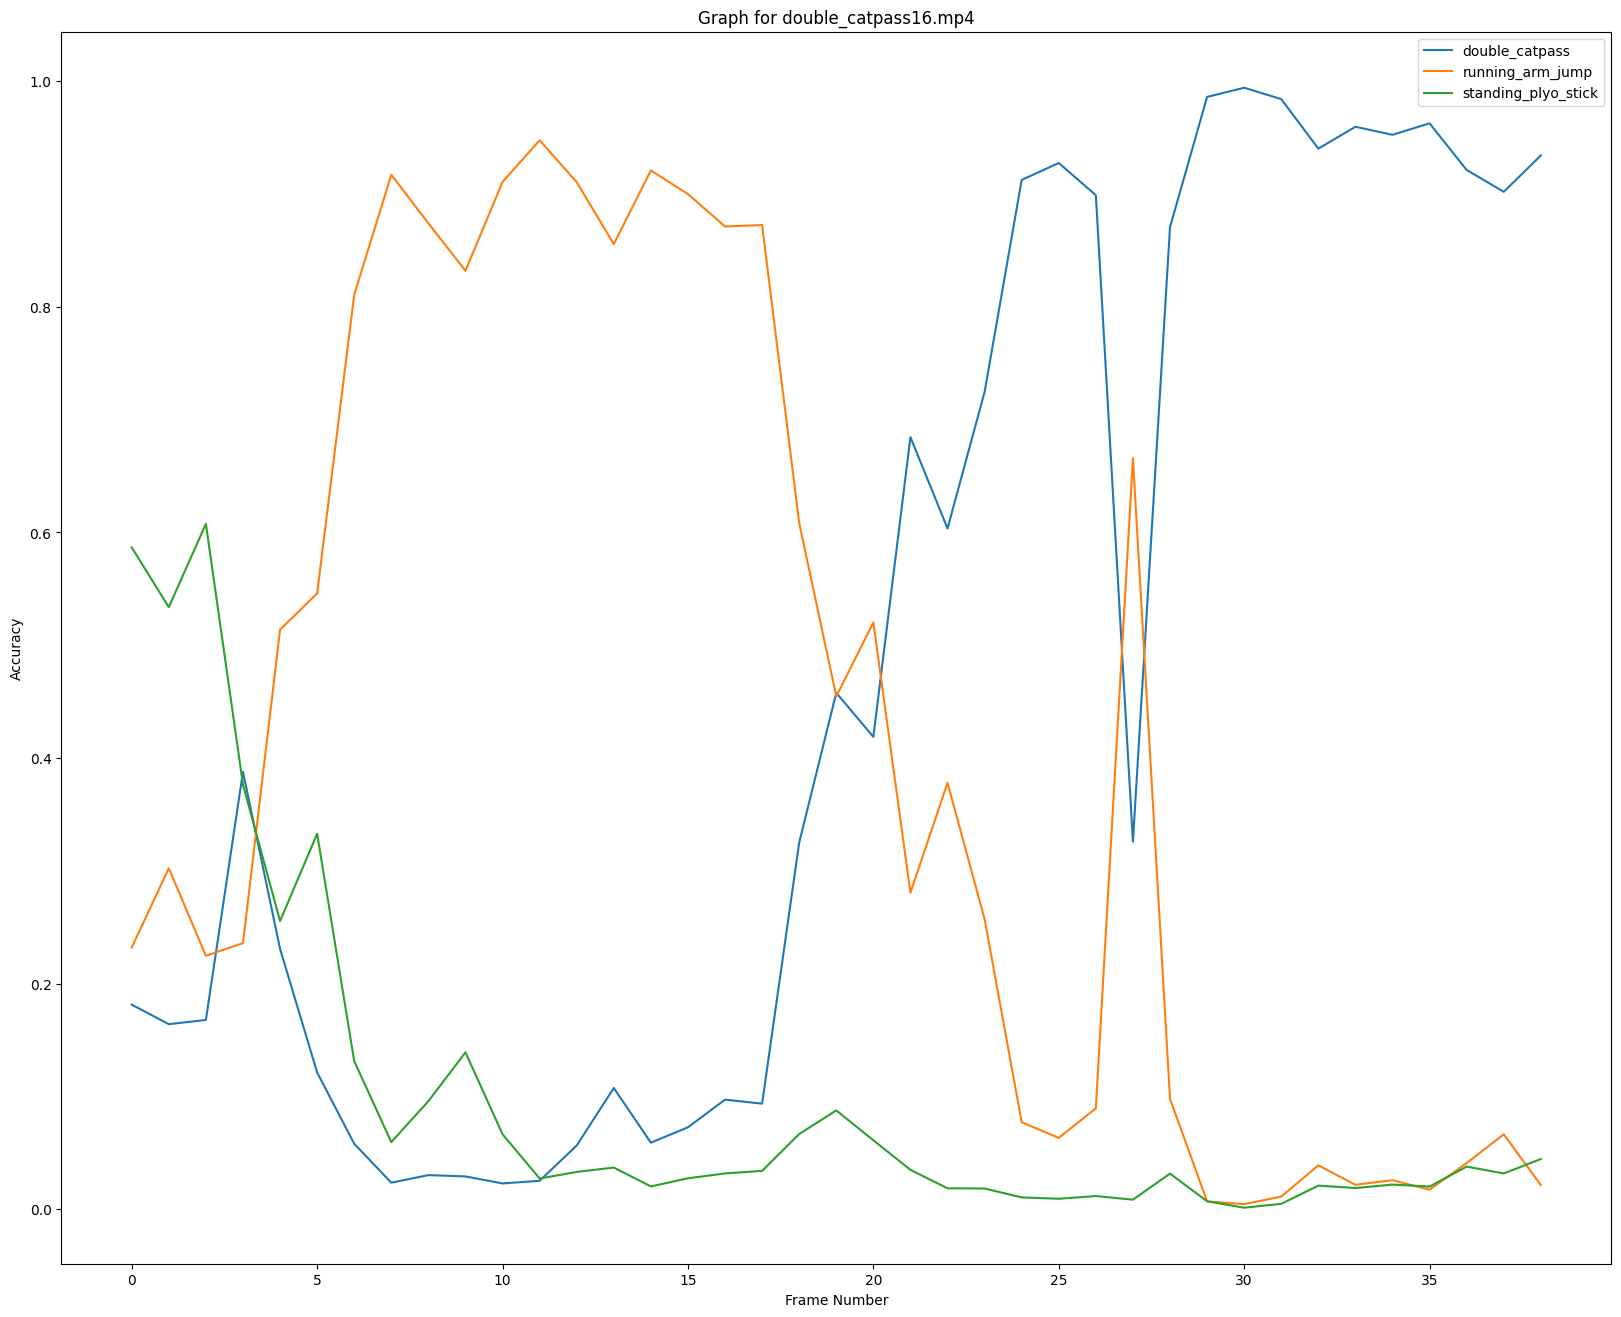

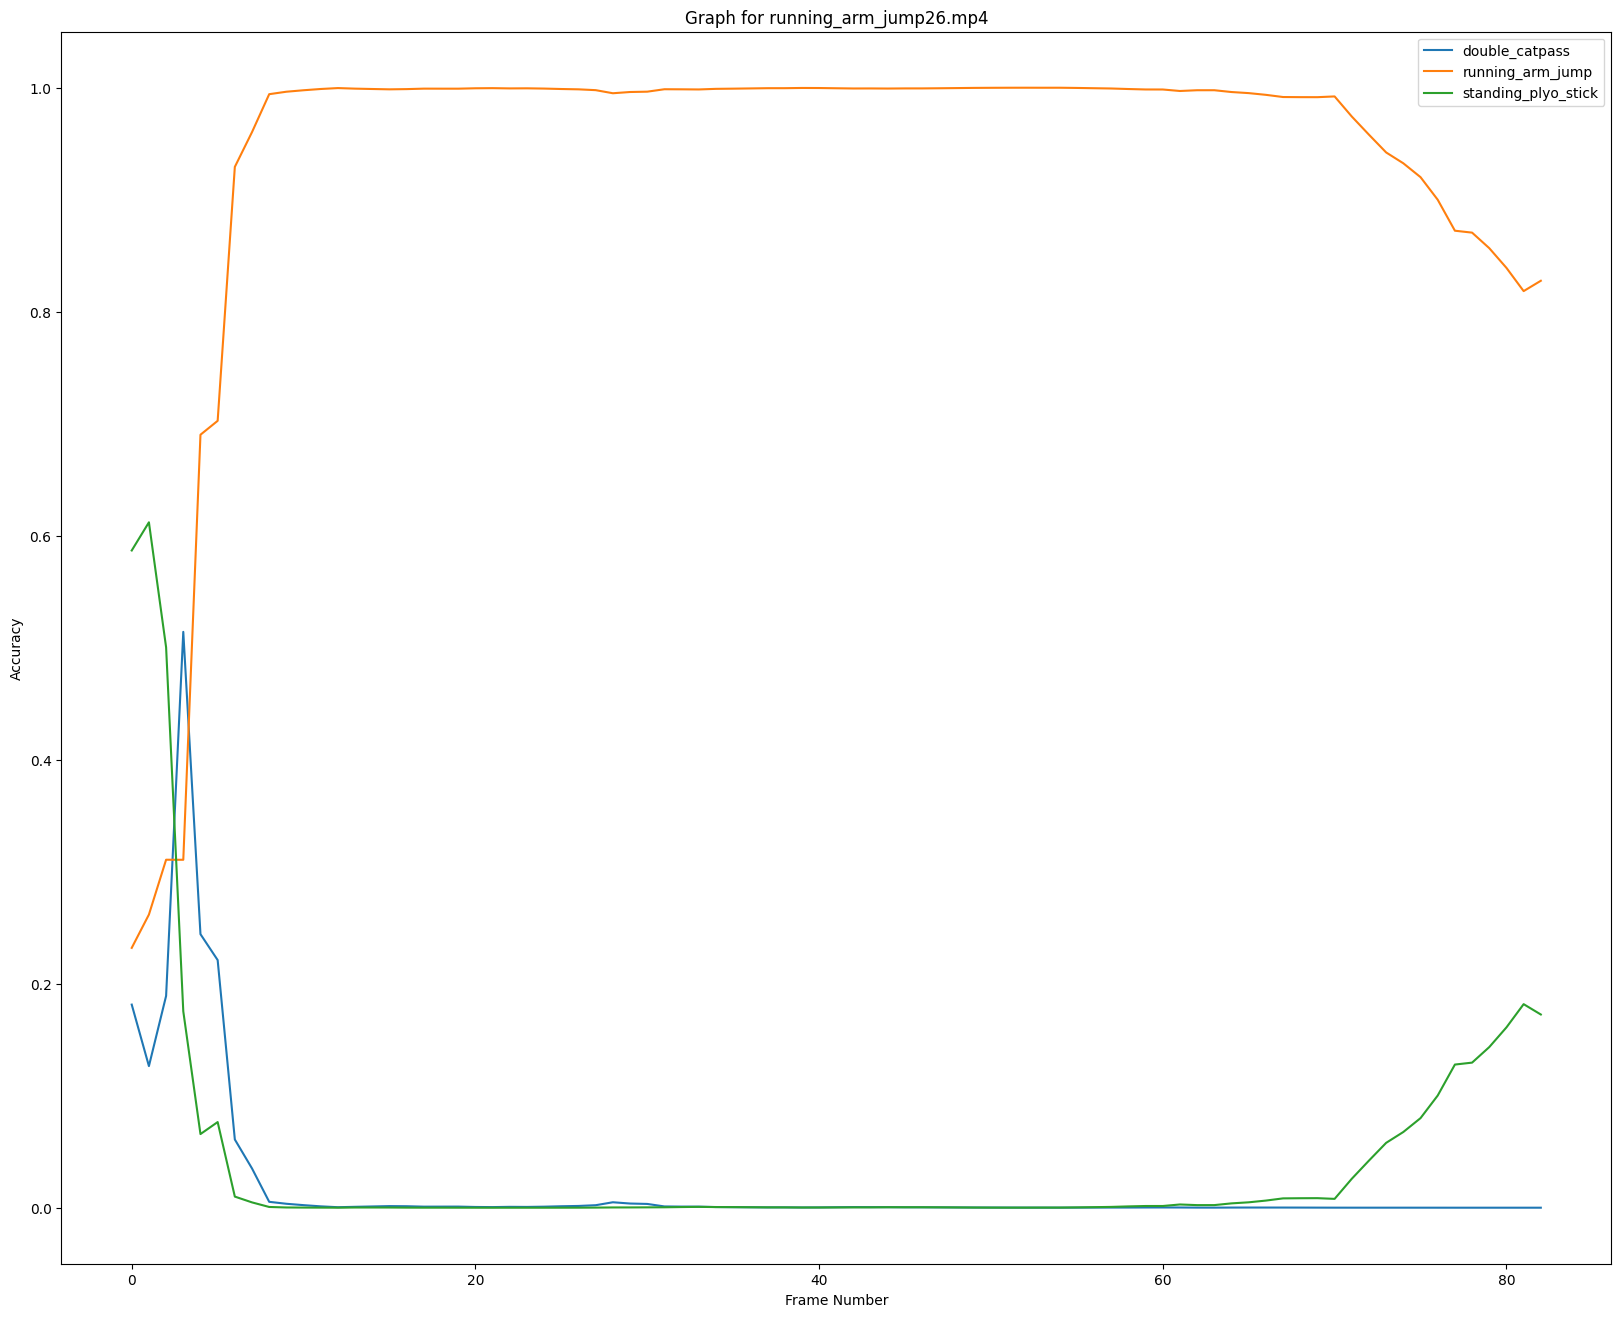

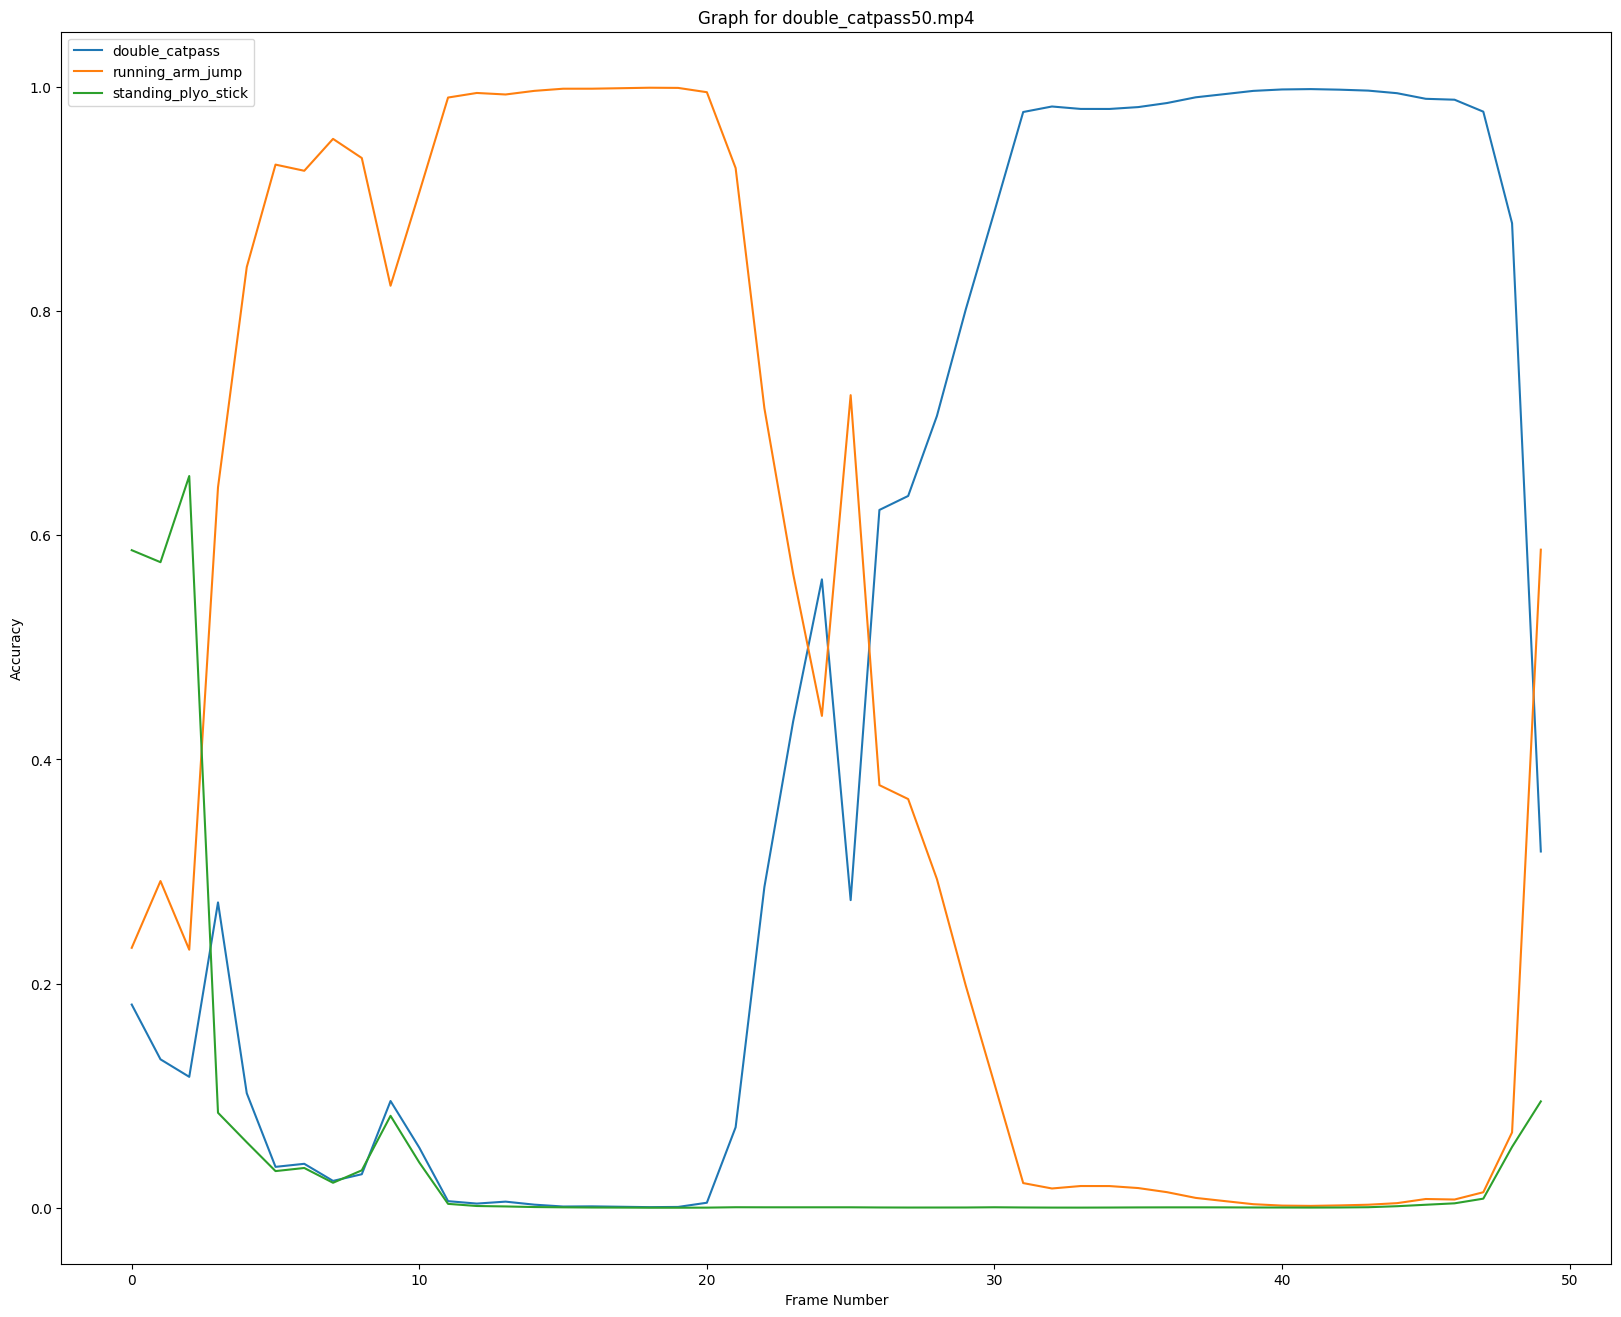

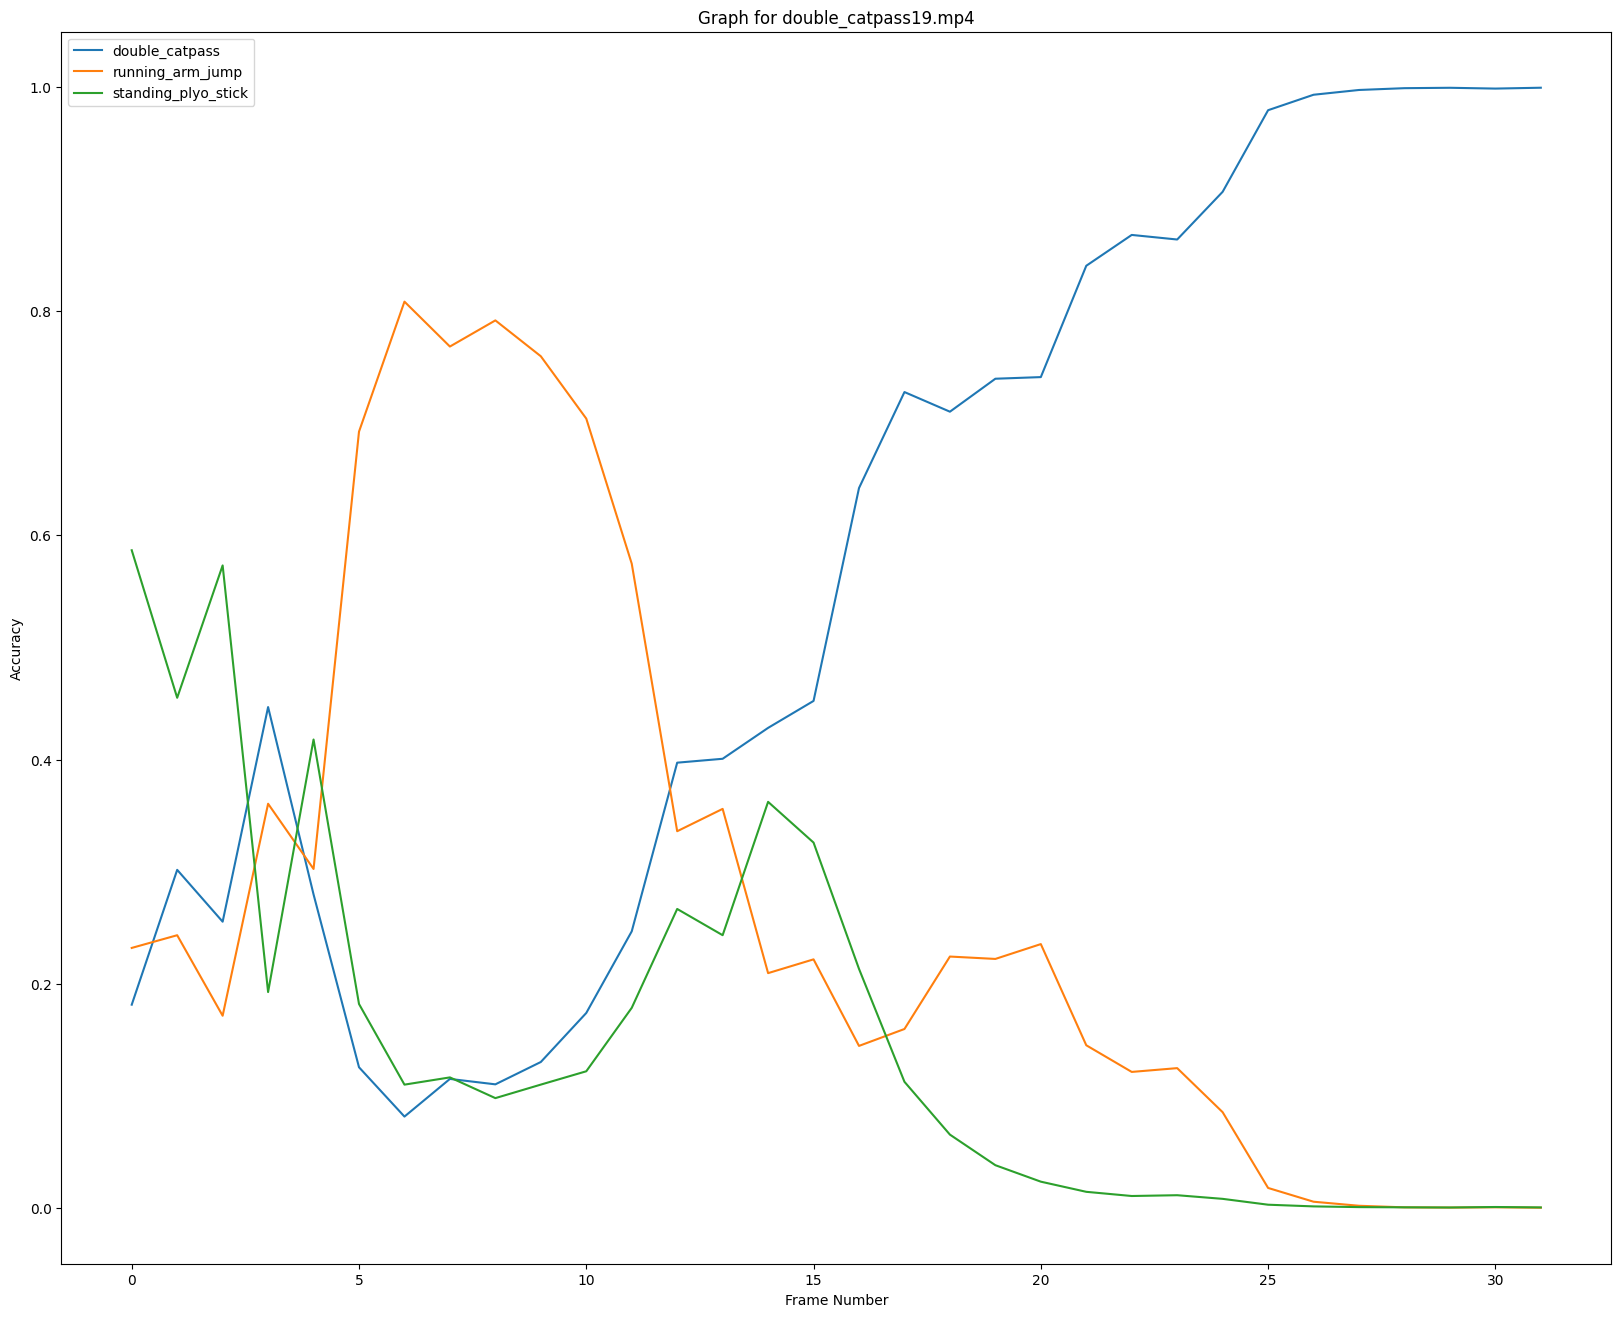

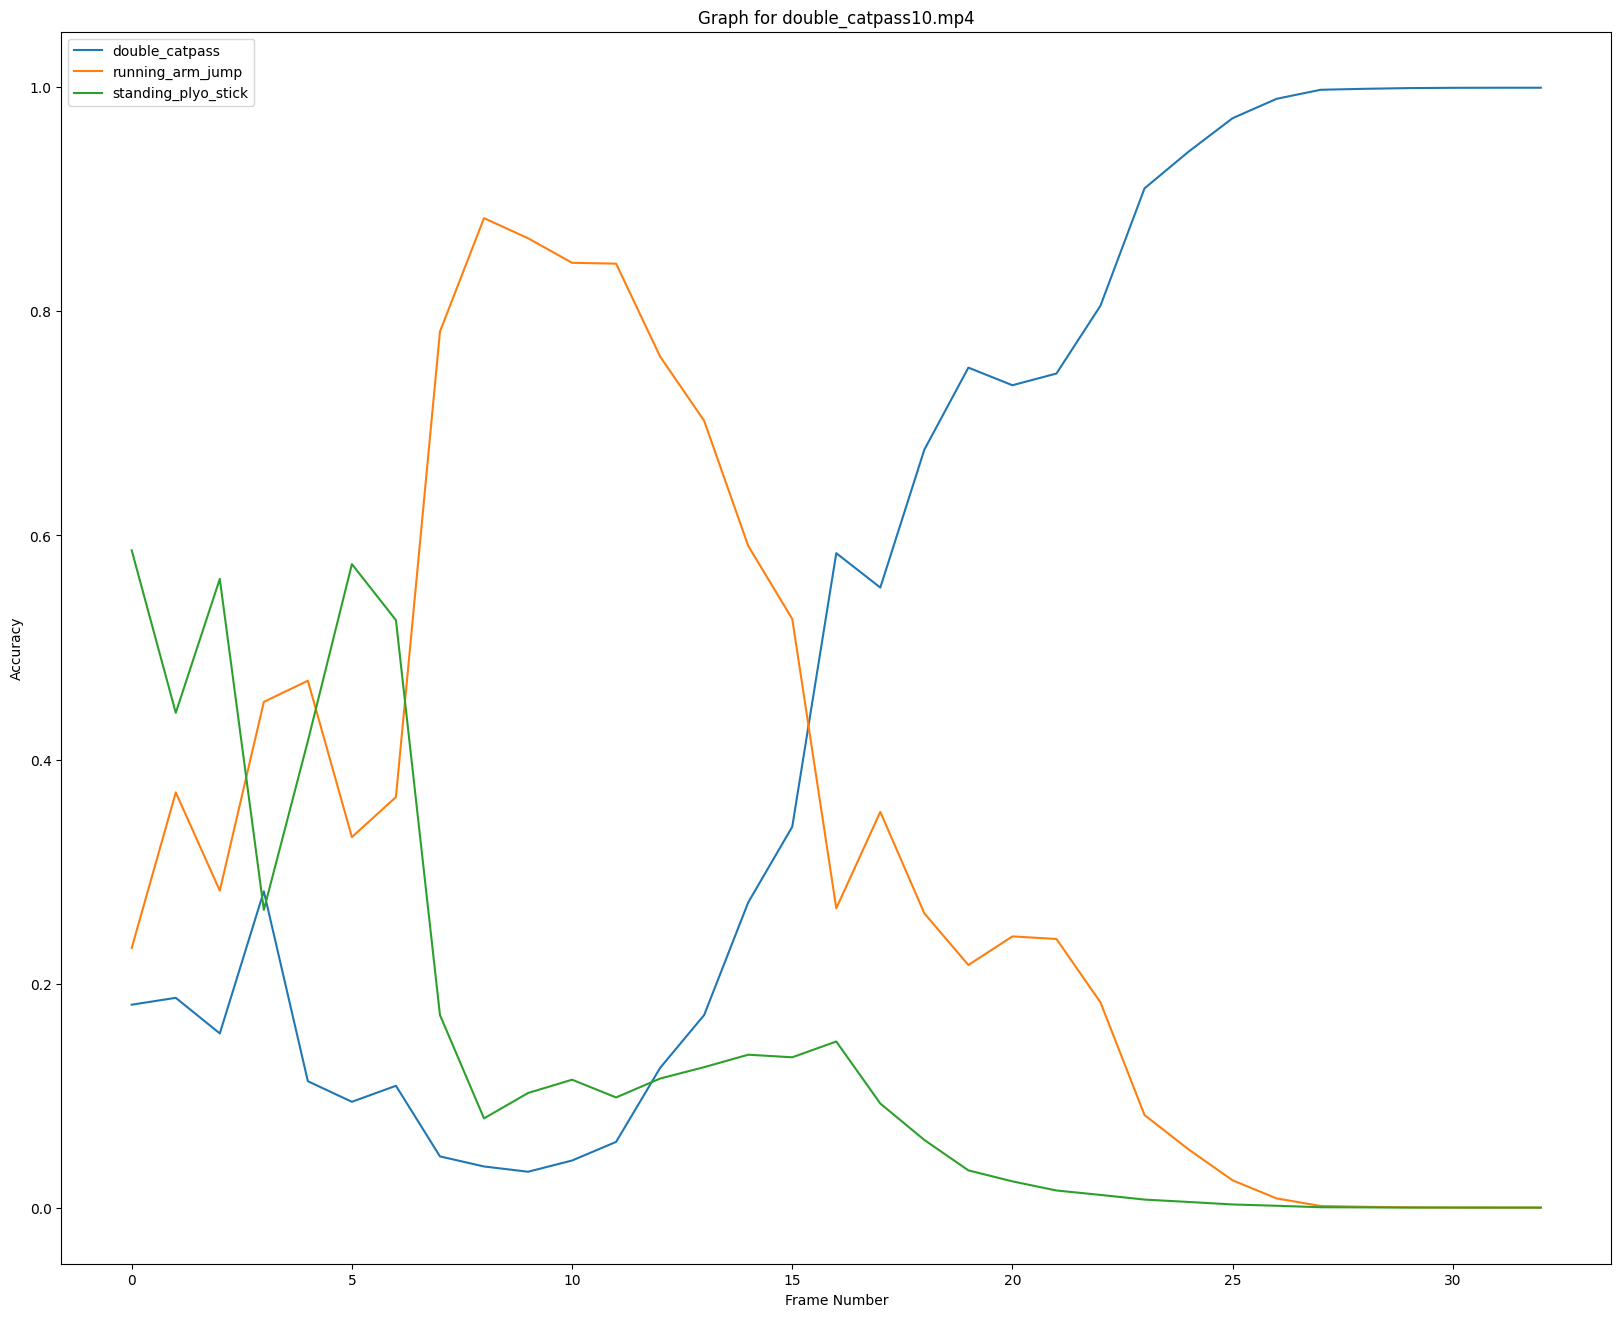

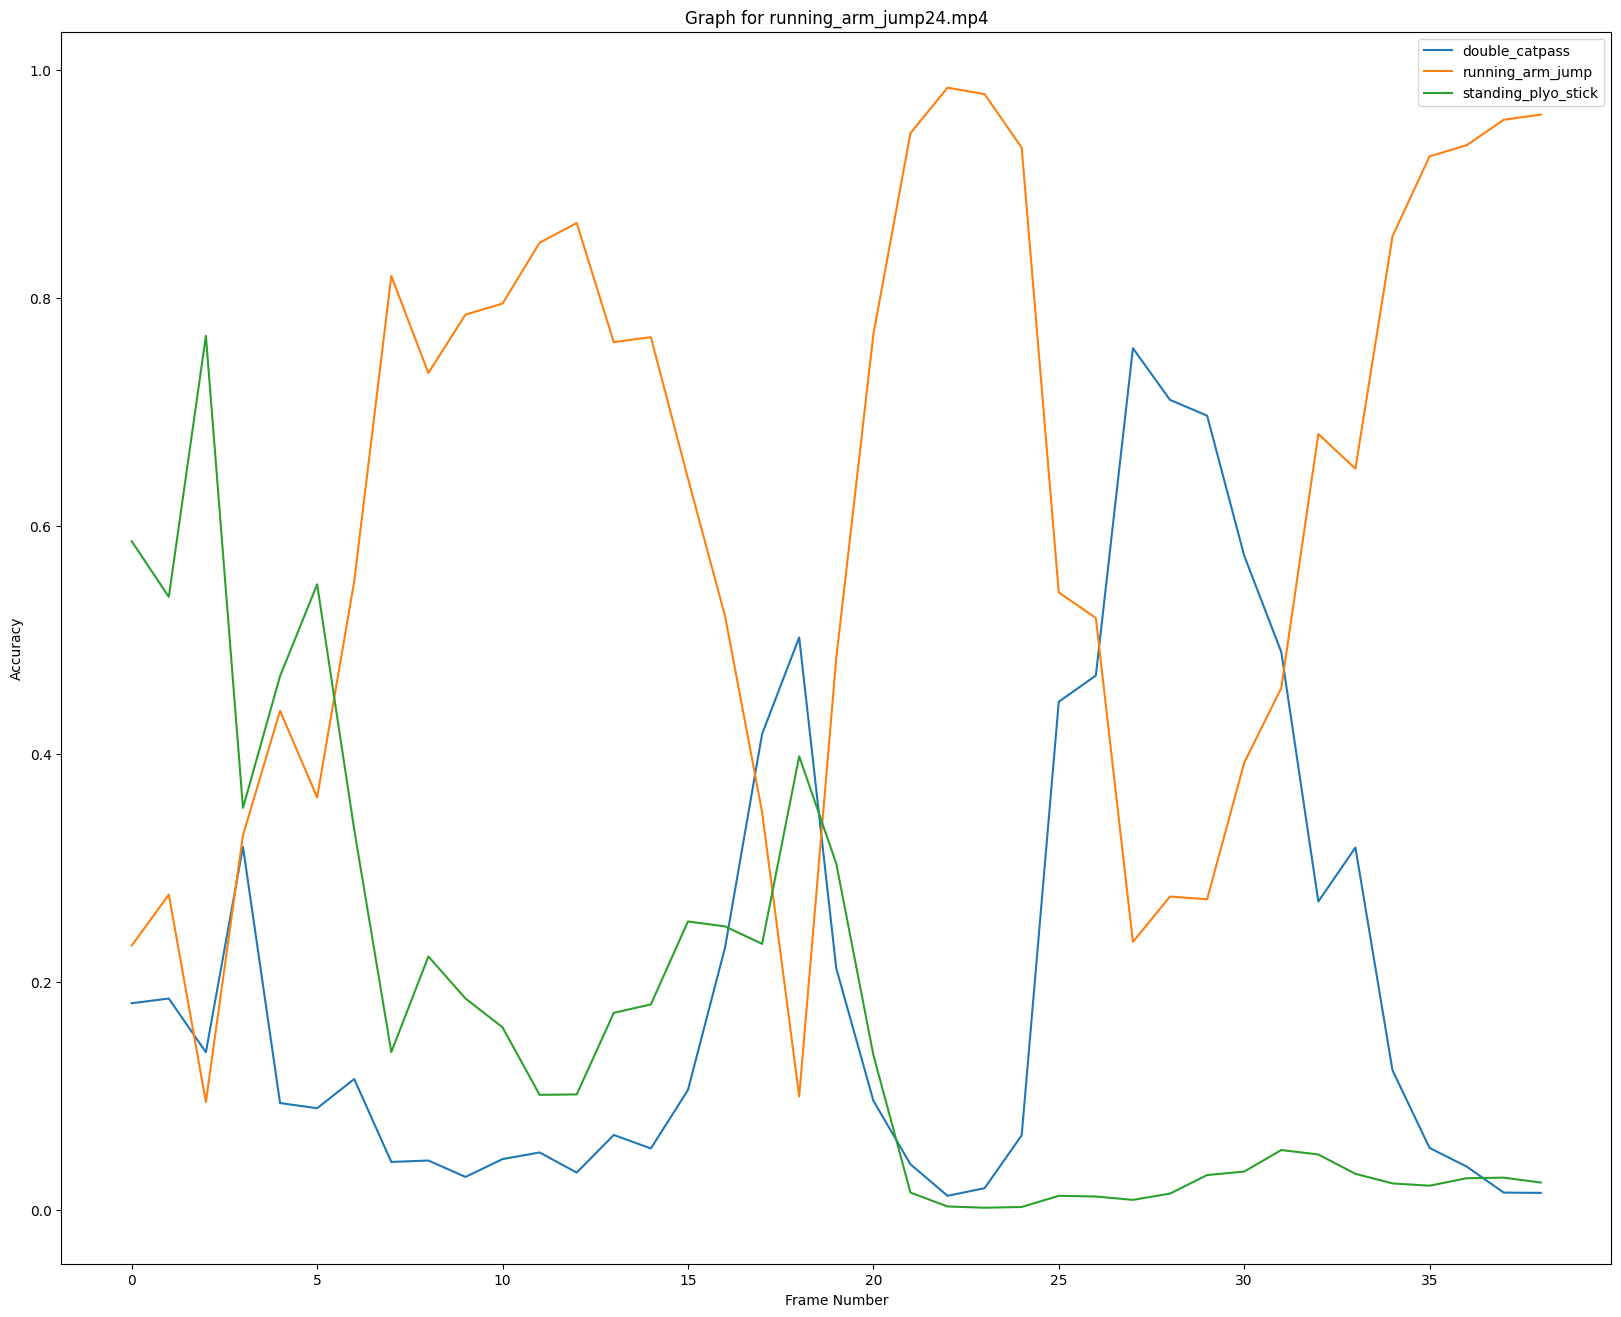

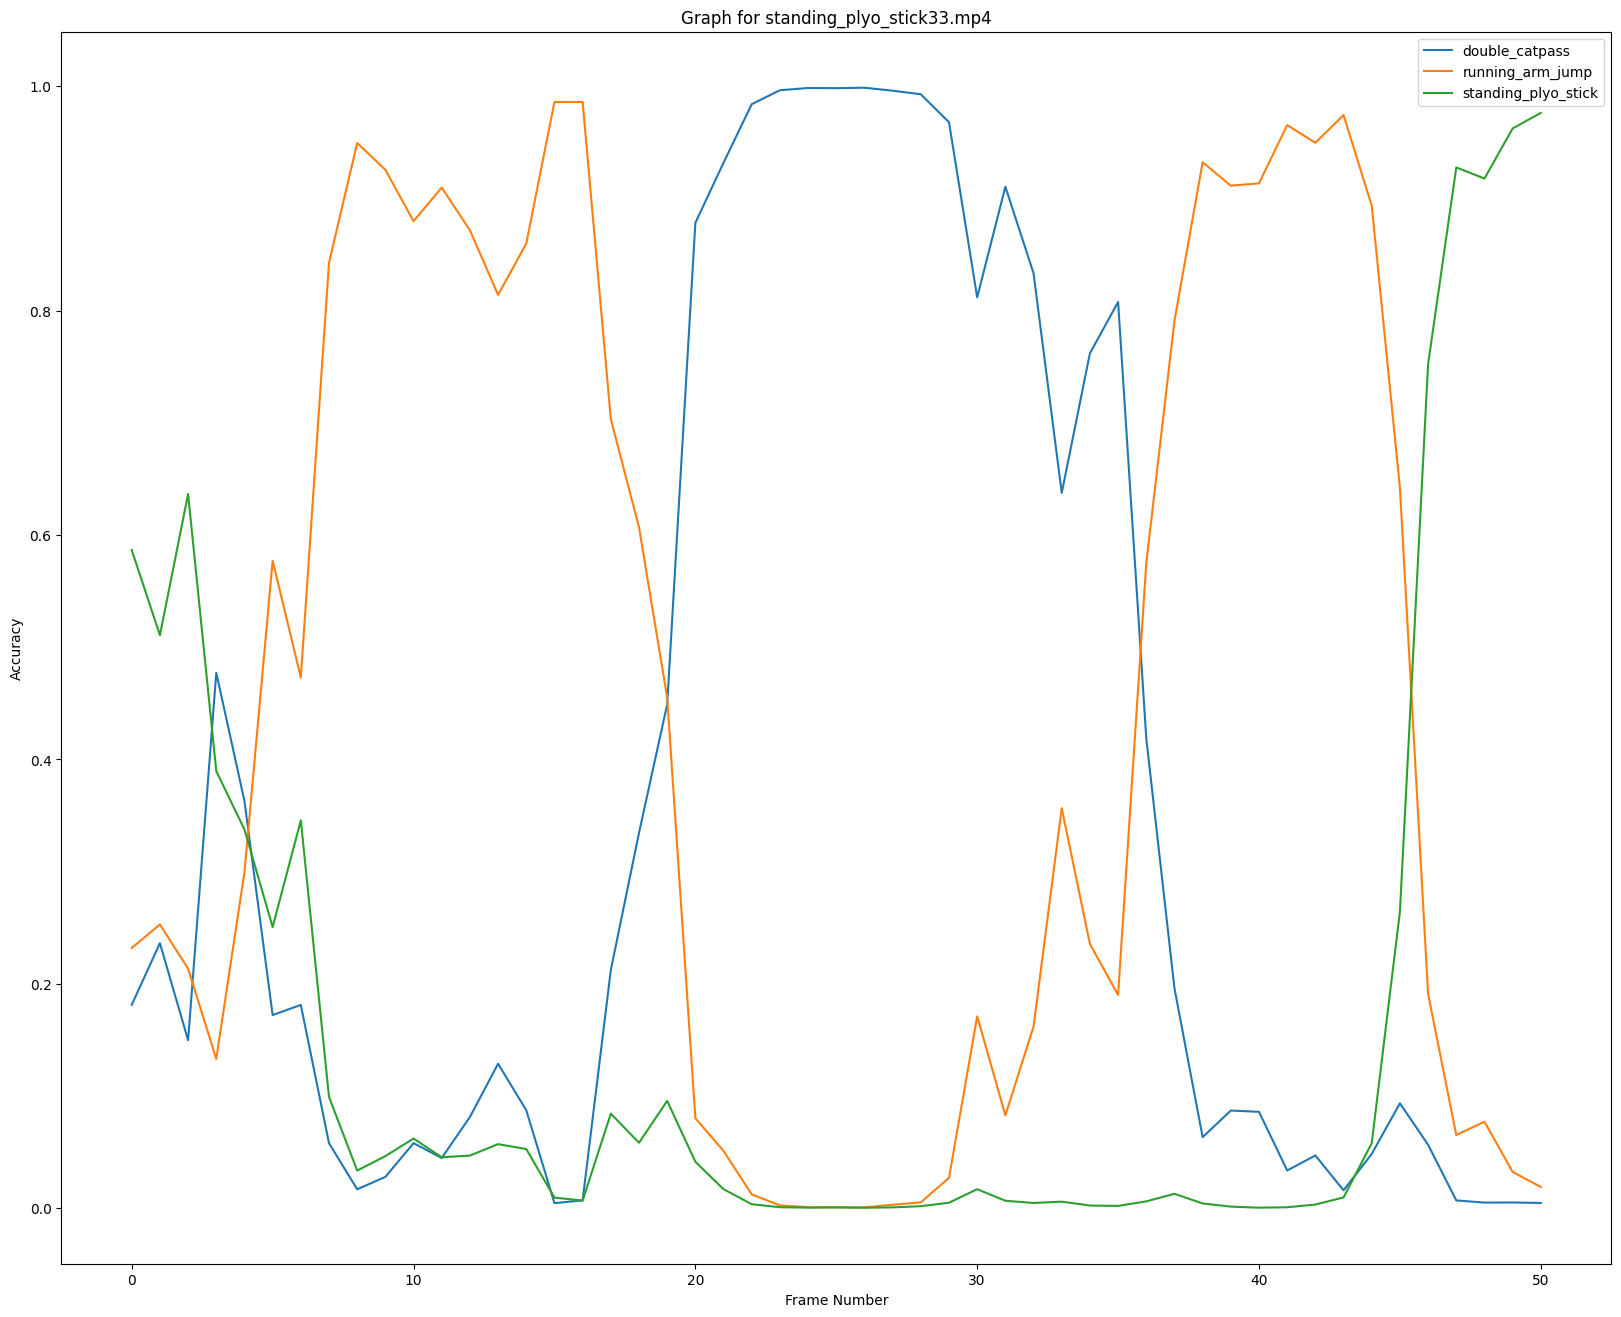

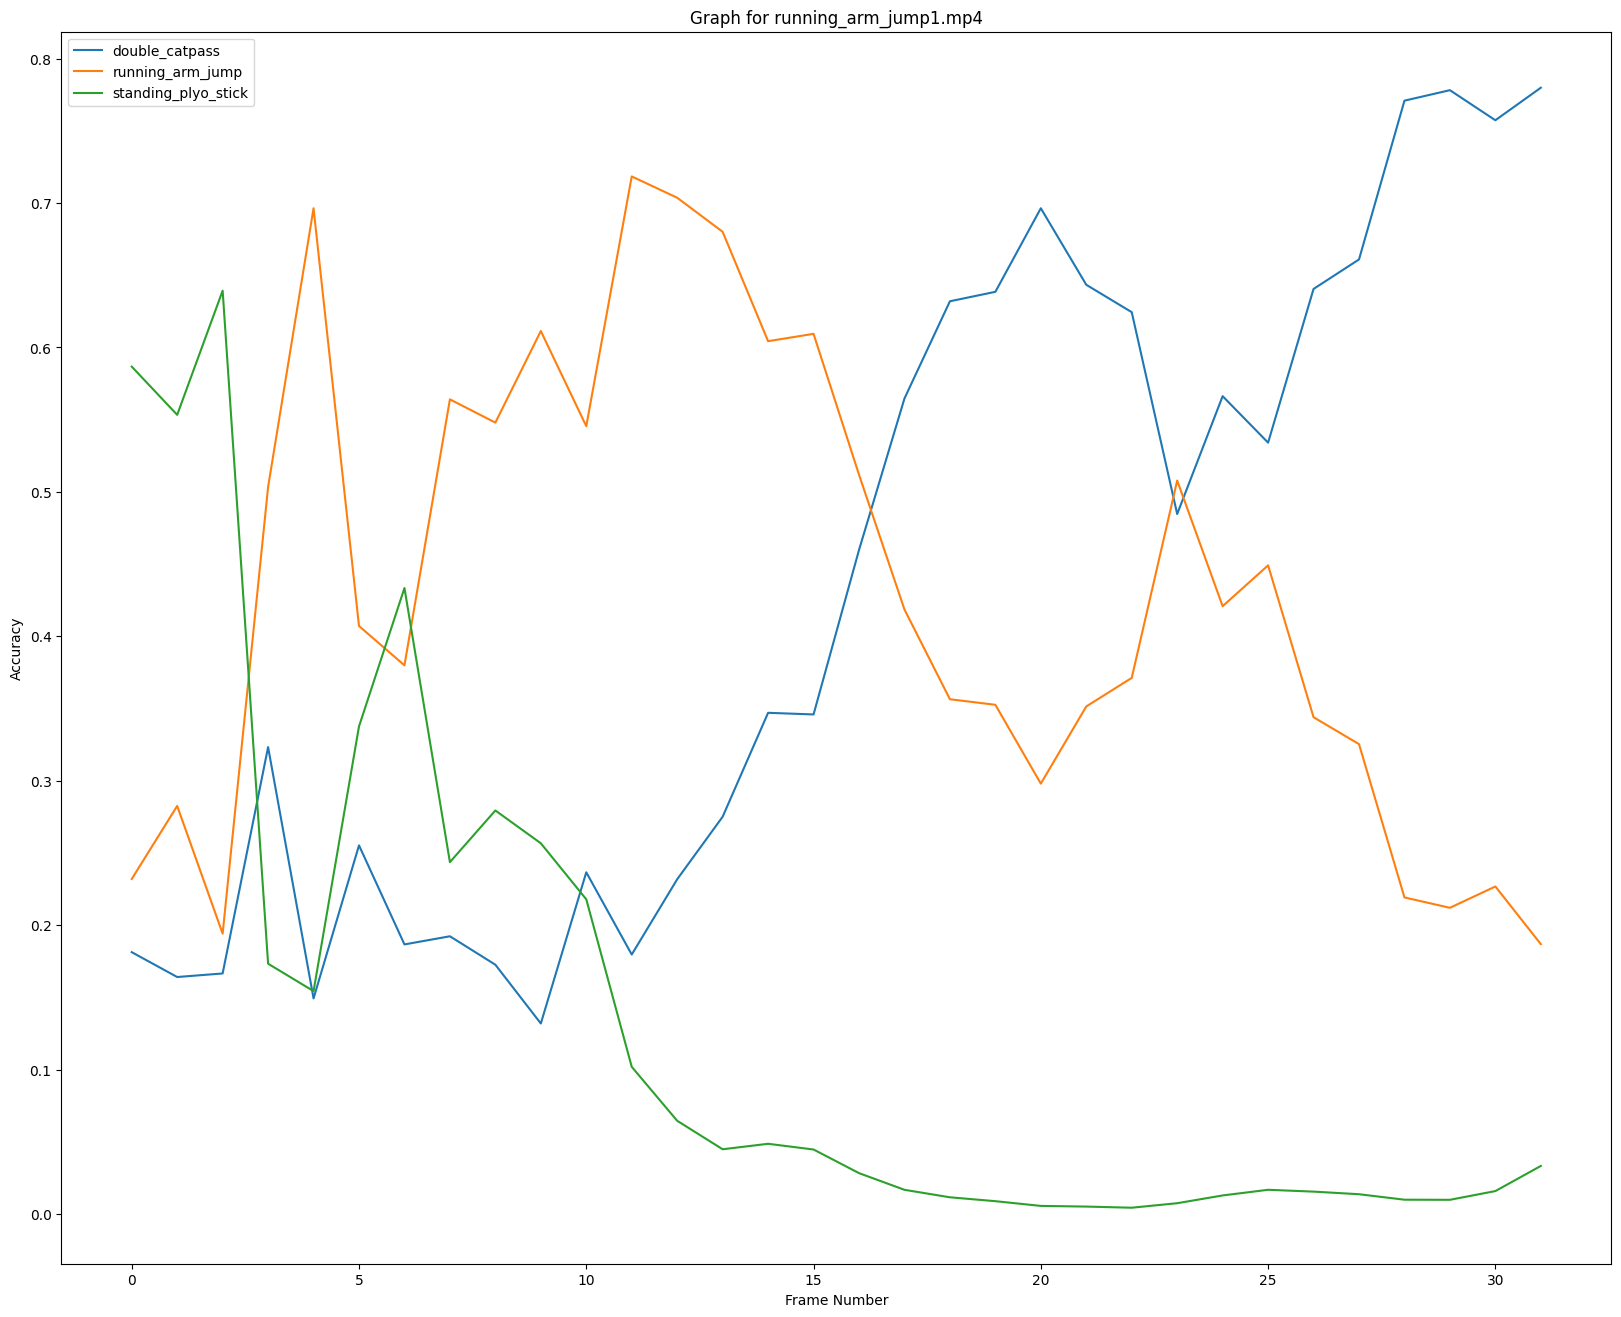

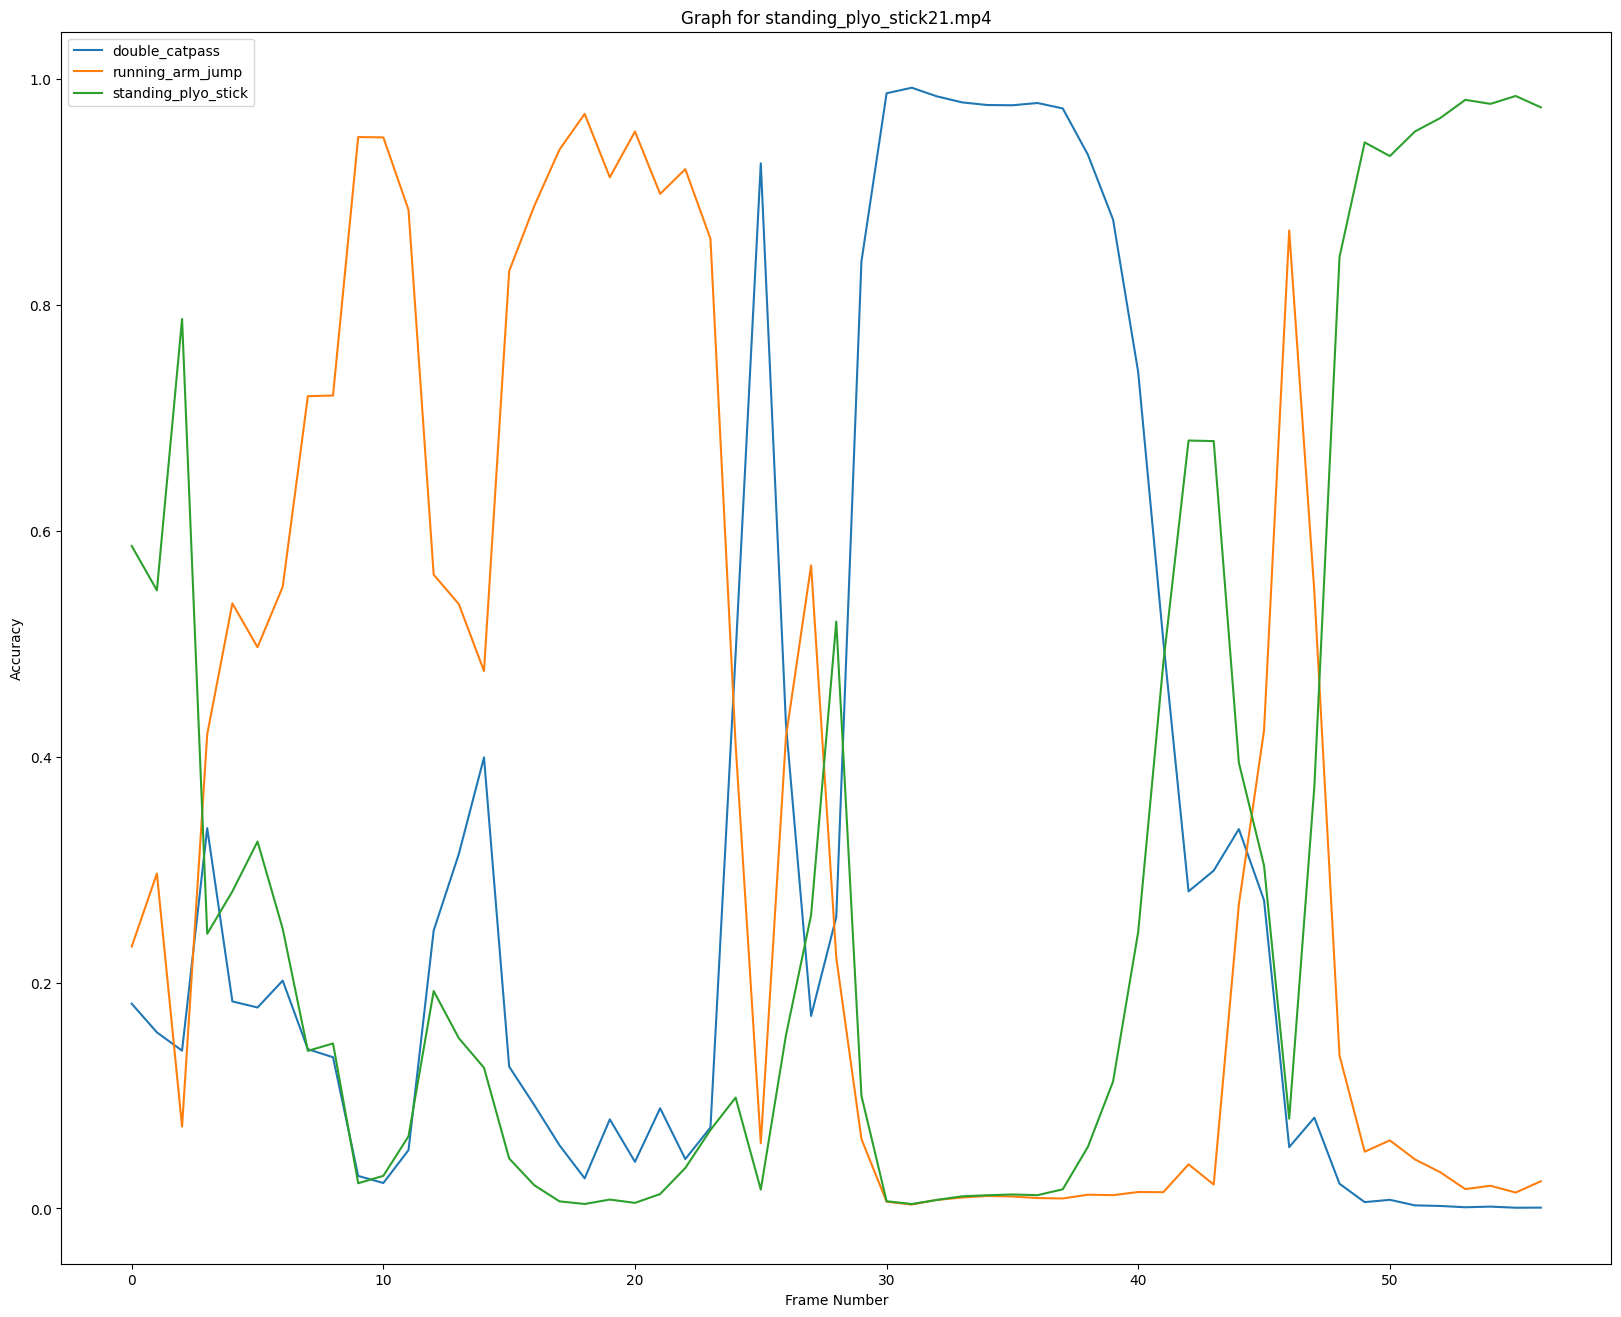

In [39]:
labels = list(test_targets)
accuracy_array = rep_counter_accuracy(test_files, str(datetime.now().strftime("%d-%m-%Y-%H-%M-%S.txt")))

In [40]:
similarity_percentage = similarity(labels, accuracy_array)

In [41]:
print(labels)
print(accuracy_array)
print(similarity_percentage)

[2, 1, 1, 1, 0, 2, 0, 2, 2, 0, 1, 0, 0, 0, 1, 2, 1, 2]
[1, 1, 1, 0, 0, 2, 0, 2, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1]
66.66666666666666


[Text(0.5, 1.0, 'Confusion Matrix of Frame Prediction Accuracy')]

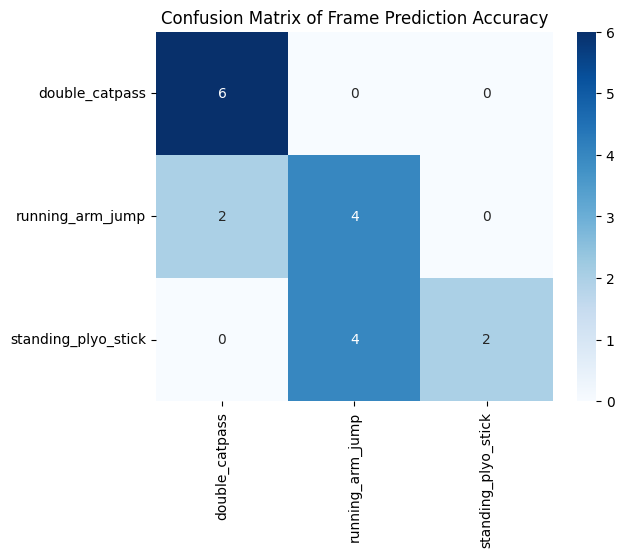

In [42]:
confusion_matrix = tf.math.confusion_matrix(labels, accuracy_array)
sns.heatmap(confusion_matrix, annot=True, cmap="Blues", xticklabels=class_names, yticklabels=class_names).set(title="Confusion Matrix of Frame Prediction Accuracy")